In [1]:
import findspark
findspark.init()
import pyspark
import pyarrow
from pyspark.sql import SQLContext
import os
import sys
from pyspark.sql import SparkSession

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
conf = pyspark.SparkConf()\
        .setAppName('spark_pipeline')\
        .setMaster('local')\
        .set('spark.driver.memory', '8g')\
        .set('spark.executor.memory', '8g')\
        .set('spark.executor.instances', 4)\
        .set('spark.executor.cores', 4)\
        .set('spark.driver.maxResultSize', '8g')\
        .set('spark.sql.shuffle.partitions', 100)\
        .set('spark.default.parallelism', 200)\
        .set('spark.sql.broadcastTimeout', 36000)\
        .set('spark.kryoserializer.buffer.max', '1024m')\
        .set('spark.sql.execution.arrow.enabled', 'false')\
        .set('spark.dynamicAllocation.enabled', "False")\
        .set('spark.port.maxRetries',30) 
sc = pyspark.SparkContext.getOrCreate(conf)
spark = pyspark.sql.SparkSession(sc)
sqlContext = SQLContext.getOrCreate(sc)  

C:\Users\Davide\anaconda3\envs\pyspark_env\Lib\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [1]:
#import os
#import sys
#from pyspark.sql import SparkSession

#os.environ['PYSPARK_PYTHON'] = sys.executable
#os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import *
from pyspark.mllib.stat import Statistics
from pyspark.sql.types import IntegerType, DoubleType, BooleanType, StringType, TimestampType
from pyspark.sql.functions import col,month,hour
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType
from pyspark.sql.types import StringType
from geopy.geocoders import Nominatim

#spark = SparkSession.Builder().appName('DDAM_Project_ovest').getOrCreate()
#sqlCtx = SQLContext(spark)

In [4]:
df = spark.read.options(inferSchema = True, delimiter = ',', header = True).csv('../../Datasets/West_Incidents.csv')

# VARIABLES EXPLORATION

in fase di analisi dei dati abbiamo selezionato le features che abbiamo ritenuto interessati e rilevanti per il nostro caso di studio ed abbiamo eliminato le restanti. (discorso sulle luci ---) 

In [5]:
# Remove not interesting variables
to_delete=['Source','Country','Weather_TimeStamp','End_Time','Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','End_Lat','End_Lng','Description','Timezone','Street','Zipcode','Airport_Code']
for col in to_delete:
    df = df.drop(col)

In [6]:
df.dtypes

[('ID', 'string'),
 ('Severity', 'int'),
 ('Start_Time', 'timestamp'),
 ('Start_Lat', 'double'),
 ('Start_Lng', 'double'),
 ('Distance(mi)', 'double'),
 ('City', 'string'),
 ('County', 'string'),
 ('State', 'string'),
 ('Temperature(F)', 'double'),
 ('Wind_Chill(F)', 'double'),
 ('Humidity(%)', 'double'),
 ('Pressure(in)', 'double'),
 ('Visibility(mi)', 'double'),
 ('Wind_Direction', 'string'),
 ('Wind_Speed(mph)', 'double'),
 ('Precipitation(in)', 'double'),
 ('Weather_Condition', 'string'),
 ('Amenity', 'boolean'),
 ('Bump', 'boolean'),
 ('Crossing', 'boolean'),
 ('Give_Way', 'boolean'),
 ('Junction', 'boolean'),
 ('No_Exit', 'boolean'),
 ('Railway', 'boolean'),
 ('Roundabout', 'boolean'),
 ('Station', 'boolean'),
 ('Stop', 'boolean'),
 ('Traffic_Calming', 'boolean'),
 ('Traffic_Signal', 'boolean'),
 ('Turning_Loop', 'boolean'),
 ('Astronomical_Twilight', 'string')]

In [8]:
rows = df.count()
cols = len(df.columns)
print(f'Il Dataset contiene {rows} records e {cols} colonne')

Il Dataset contiene 421456 records e 32 colonne


In [9]:
column_types = dict(df.dtypes)

numeric_columns = []
boolean_columns = []
string_columns = []
timestamp_columns = []

for column, data_type in column_types.items():
    if data_type == 'int' or data_type == 'double':
        numeric_columns.append(column)
    elif data_type == 'boolean':
        boolean_columns.append(column)
    elif data_type == 'string':
        string_columns.append(column)
    elif data_type == 'timestamp':
        timestamp_columns.append(column)

# Mostra i risultati
print("Colonnes numeriche:", numeric_columns)
print("Colonnes booleane:", boolean_columns)
print("Colonnes stringhe:", string_columns)
print("Colonnes timestamp:", timestamp_columns)

print(len(numeric_columns)+len(boolean_columns)+len(string_columns)+len(timestamp_columns))

Colonnes numeriche: ['Severity', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']
Colonnes booleane: ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']
Colonnes stringhe: ['ID', 'City', 'County', 'State', 'Wind_Direction', 'Weather_Condition', 'Astronomical_Twilight']
Colonnes timestamp: ['Start_Time']
32


In [10]:
unique_weather_conditions = df.select("Weather_Condition").distinct().collect()
# Mostra i valori unici
for row in unique_weather_conditions:
    print(row["Weather_Condition"])

Smoke
Showers in the Vicinity
Cloudy
Light Rain
Light Rain / Windy
Partly Cloudy / Windy
Cloudy / Windy
Fog
Partly Cloudy
Light Drizzle
Thunder in the Vicinity
Haze
Fair
Mostly Cloudy
Fair / Windy
Mostly Cloudy / Windy
Smoke / Windy
Haze / Windy
Heavy Rain
Rain / Windy
Thunder
Mist
Light Rain with Thunder
Patches of Fog
Rain
Drizzle
T-Storm
Light Snow
Shallow Fog
Light Snow / Windy
N/A Precipitation
Light Freezing Drizzle
Fog / Windy
Snow / Windy
Wintry Mix
Sleet
Heavy T-Storm
Snow
Heavy Snow
Light Freezing Rain
Heavy Rain / Windy
Widespread Dust
Heavy Snow / Windy
Small Hail
Heavy T-Storm / Windy
Widespread Dust / Windy
Rain Shower
Squalls
Blowing Dust / Windy
Blowing Snow / Windy
Blowing Dust
Snow and Thunder
Hail
Heavy Drizzle
Drizzle and Fog
Light Sleet / Windy
Light Rain Shower
Light Freezing Rain / Windy
Light Drizzle / Windy
Drizzle / Windy
Thunder / Windy
Wintry Mix / Windy
Thunder and Hail
Light Snow with Thunder
T-Storm / Windy
None


In [11]:
#Renaming some variables
for col in numeric_columns:
    new_col = (
        col.replace("(mi)", "_mi")
           .replace("(F)", "_F")
           .replace("(%)", "_perc")
           .replace("(in)", "_in")
           .replace("(mph)", "_mph")
    )
    df = df.withColumnRenamed(col, new_col)

# DATA UNDERSTANDING

In [11]:
# df.show()

In [12]:
# Count distinct values columns
#for col in df.columns:
#    x=df.select(col).distinct().count()
#    print('Column',col, 'has',x,'distinct values')


### verifico quanti e quali missing values ho.  

In [12]:
# voglio controllare quali sono i missing value restanti
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull(c), c)).alias(c) for c in ['Temperature_F','Wind_Chill_F','Humidity_perc','Pressure_in','Visibility_mi','Wind_Direction','Wind_Speed_mph','Precipitation_in','Weather_Condition','City','Astronomical_Twilight']])

missing.show()

+-------------+------------+-------------+-----------+-------------+--------------+--------------+----------------+-----------------+----+---------------------+
|Temperature_F|Wind_Chill_F|Humidity_perc|Pressure_in|Visibility_mi|Wind_Direction|Wind_Speed_mph|Precipitation_in|Weather_Condition|City|Astronomical_Twilight|
+-------------+------------+-------------+-----------+-------------+--------------+--------------+----------------+-----------------+----+---------------------+
|        10302|       14340|        10722|       9239|        10030|         12830|         12826|           27482|             9506|   6|                  964|
+-------------+------------+-------------+-----------+-------------+--------------+--------------+----------------+-----------------+----+---------------------+



## Per analisi successive e per verificare l'andamento degli incidenti 'nel tempo' abbiamo aggiunto:
 colonne relative alla stagione, mese, giorno della settimana, fascia oraria  e weather_condition
 
le condizioni meteo sono state discretizzate raggruppandole in classi). 

In [7]:
from pyspark.sql.functions import col
from pyspark.sql.functions import month,hour
# creo la colonna 'month'
df=df.withColumn("month", month("Start_Time"))
# creo la colonna 'day_of_the_week'
df=df.withColumn("day_of_the_week", date_format("Start_Time",'EEEE'))  
# creo la colonna'hour'
df=df.withColumn("hour", hour("Start_Time"))


def season(month_):
    if month_>=3 and month_<=5:
        return 'Spring'
    elif month_>=6 and month_<=8:
        return 'Summer'
    elif month_>=9 and month_<=11:
        return 'Autumn'
    else:
        return 'Winter'

udf_season = udf(season, StringType())
df = df.withColumn("season", udf_season(col("month")))


In [8]:
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
def workingDay_weekend(day_of):
    ins={'Monday','Tuesday','Wednesday','Thursday','Friday'}
    if day_of in ins:
        return 'WorkingDay'
    else:
        return 'Weekend'

udf_workingDay_weekend = udf(workingDay_weekend, StringType())
df = df.withColumn("Working_Weekend", udf_workingDay_weekend(col("day_of_the_week")))

In [9]:
# discretizzo il WEATHER 
def update_weather_values(df):
    df_new = df.withColumn(
        "Weather_Condition",
        when(
            col("Weather_Condition").isin("Fair", "Fair / Windy", "Thunder in the Vicinity", "Showers in the Vicinity"),
            "Normal"
        ).when(
            col("Weather_Condition").isin(
                "Fog", "Smoke", "Smoke / Windy", "Haze", "Shallow Fog",
                "Patches of Fog", "Haze / Windy", "Fog / Windy", "Mist",
                "Widespread Dust", "Widespread Dust / Windy", "Blowing Dust / Windy",
                "Blowing Dust", "Drizzle and Fog", "Shallow Fog / Windy"
            ),
            "Foggy"
        ).when(
            col("Weather_Condition").isin(
                "Cloudy", "Cloudy / Windy", "Partly Cloudy", "Mostly Cloudy",
                "Partly Cloudy / Windy", "Mostly Cloudy / Windy"
            ),
            "Cloudy"
        ).when(
            col("Weather_Condition").isin(
                "Wintry Mix", "Sleet", "Light Snow / Windy", "Snow", "Heavy Snow with Thunder",
                "Light Snow", "Heavy Snow", "Light Freezing Rain",
                "Heavy Snow / Windy", "Snow / Windy", "Small Hail", "Light Snow and Sleet / Windy",
                "Blowing Snow / Windy", "Light Sleet / Windy", "Snow and Thunder",
                "Hail", "Wintry Mix / Windy", "Light Snow with Thunder", "Snow and Sleet / Windy", "Heavy Sleet",
                "Thunder and Hail", "Light Sleet", "Light Snow and Sleet", "Snow and Sleet", "Blowing Snow", "Drifting Snow / Windy"
            ),
            "Snow"
        ).when(
            col("Weather_Condition").isin(
                "Rain", "Light Drizzle", "Light Rain with Thunder", "T-Storm", "Tornado",
                "Drizzle", "Heavy Rain", "Thunder", "Light Rain",
                "Light Rain / Windy", "Rain / Windy", "Heavy Rain / Windy",
                "Heavy T-Storm", "Rain Shower", "Squalls", "Heavy T-Storm / Windy",
                "Heavy Drizzle", "Light Rain Shower", "Light Drizzle / Windy",
                "Light Freezing Rain / Windy", "Drizzle / Windy", "Thunder / Windy",
                "T-Storm / Windy", "N/A Precipitation", "Light Freezing Drizzle", "Freezing Rain", "Freezing Rain / Windy", "Squalls / Windy"
            ),
            "Rain"
        ).otherwise(col("Weather_Condition"))
    )

    return df_new

In [10]:
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
df=update_weather_values(df) # applico funzione per il tempo 

# Scatter plot + Hist

ricorda: Hist per month, season, dayoftheweek, hour 

SOTTO: Histogramma che mostra l'andamento degli incidenti nelle ore rispetto a Week-end e working day. 

<Axes: xlabel='hour', ylabel='count'>

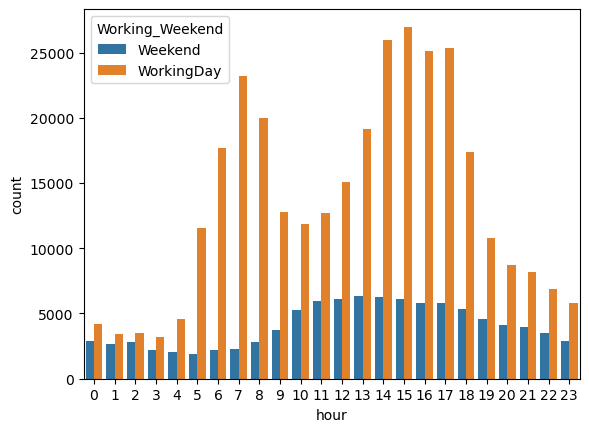

In [11]:
severity_state_count = df.groupBy('hour', 'Working_Weekend').count().toPandas()
sns.barplot(x='hour', y="count", data=severity_state_count, hue='Working_Weekend')

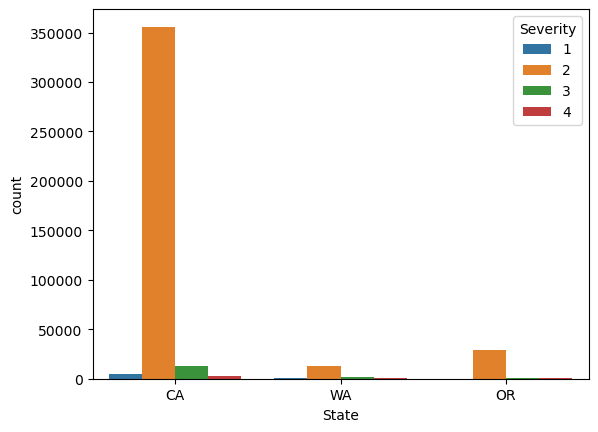

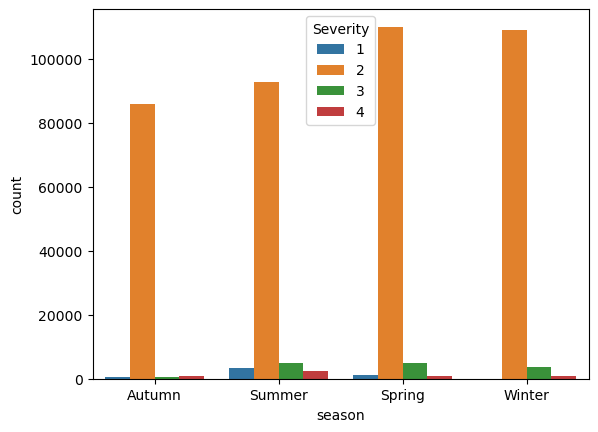

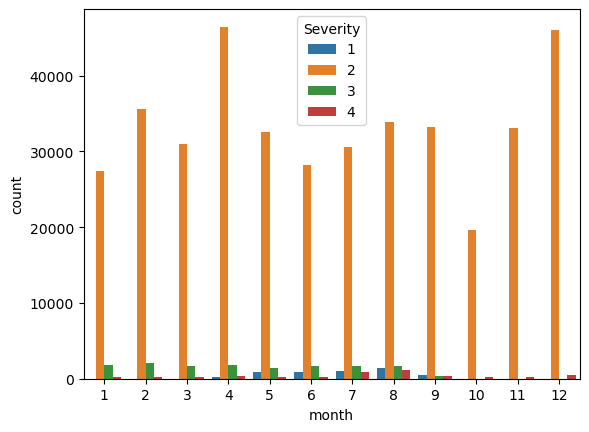

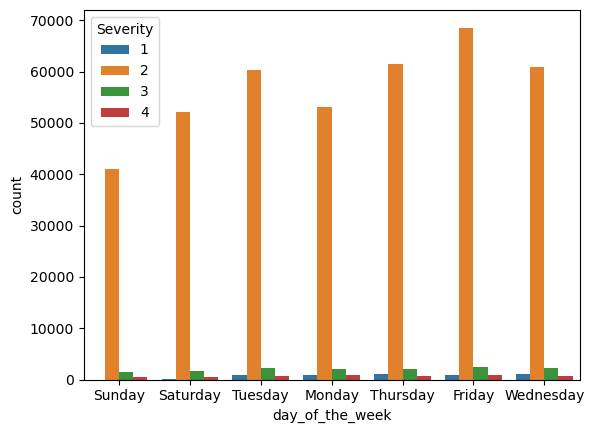

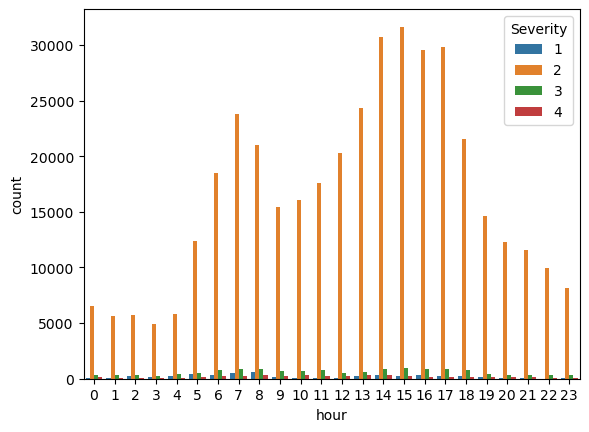

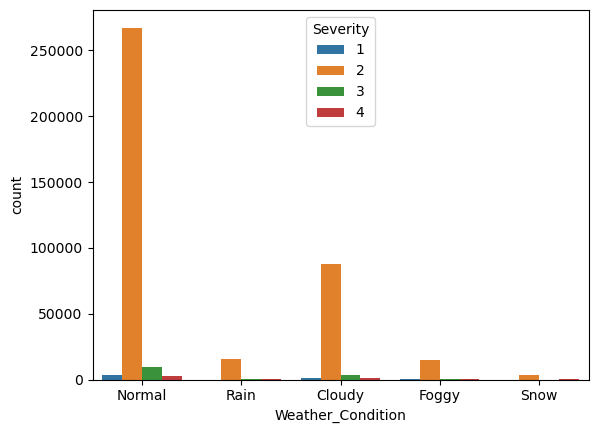

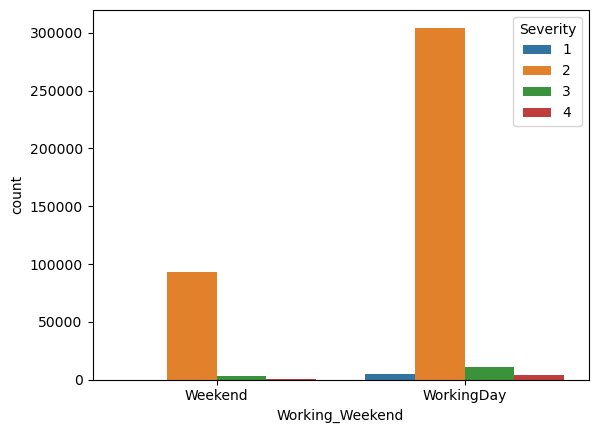

In [12]:
list_=['State', 'season','month','day_of_the_week','hour','Weather_Condition','Working_Weekend']
for col in list_:
    severity_state_count = df.groupBy(col, 'Severity').count().toPandas()
    sns.barplot(x=col, y="count", data=severity_state_count, hue='Severity')
    plt.show()

23/12/02 09:37:06 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


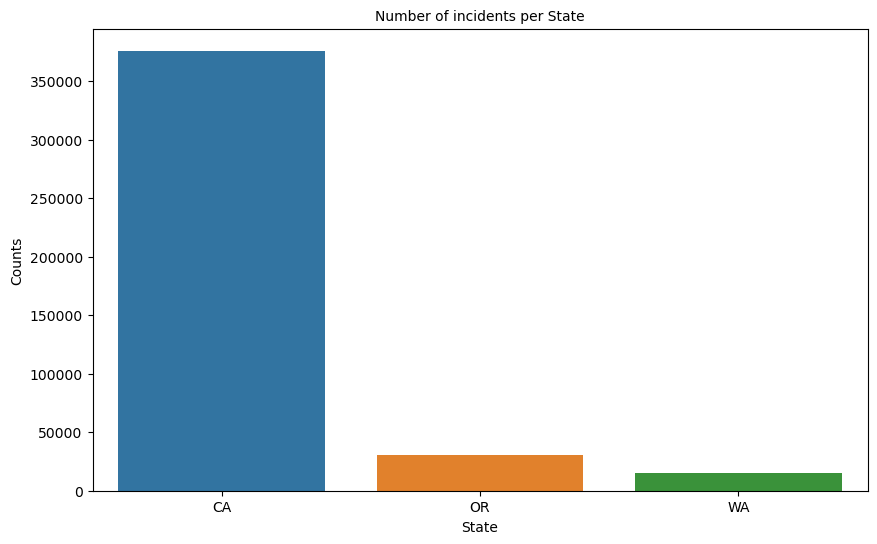

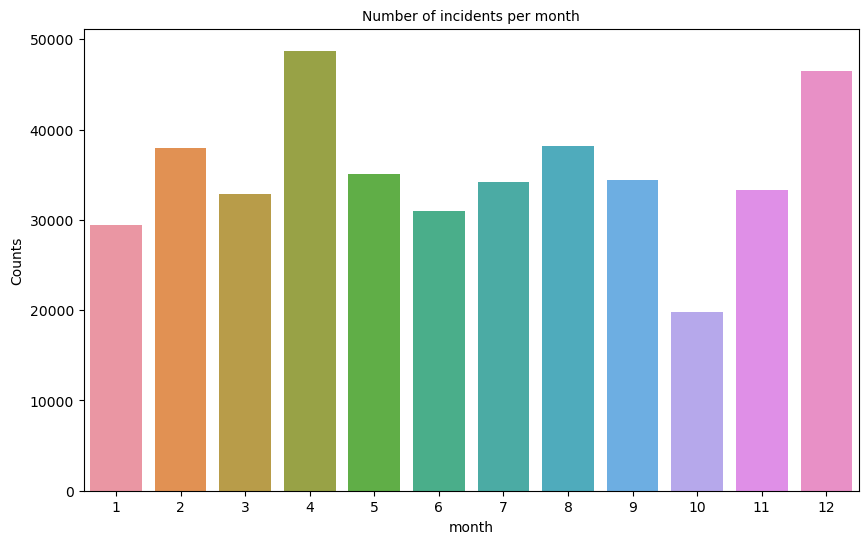

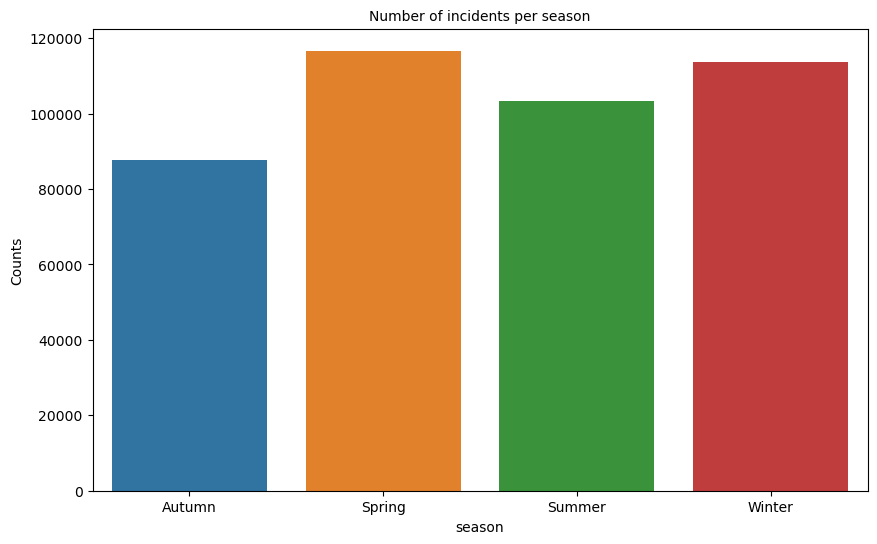

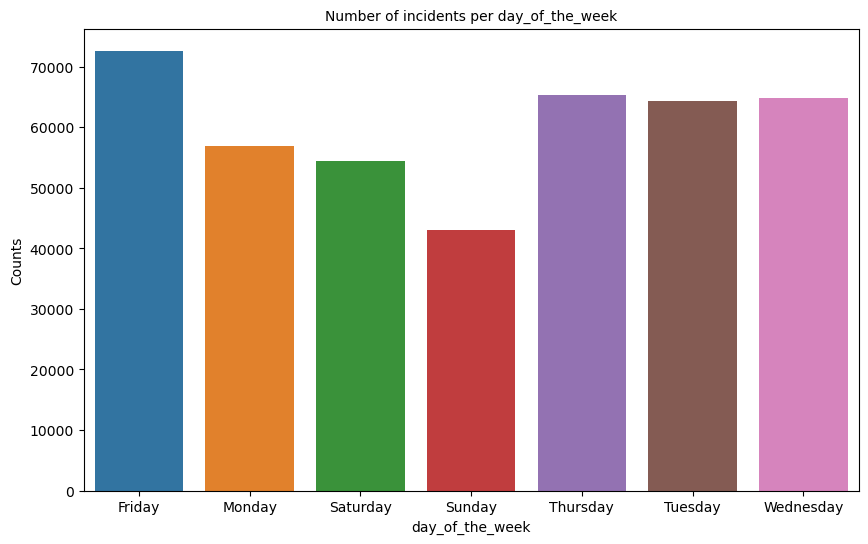

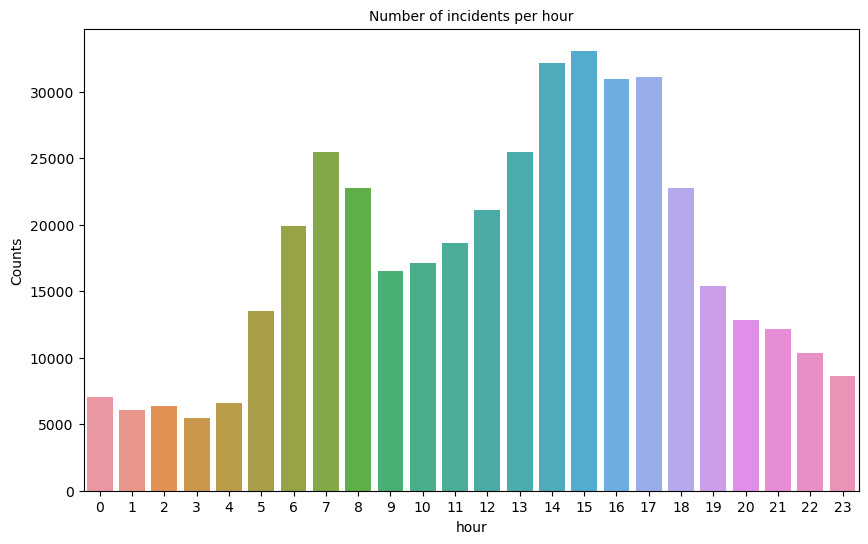

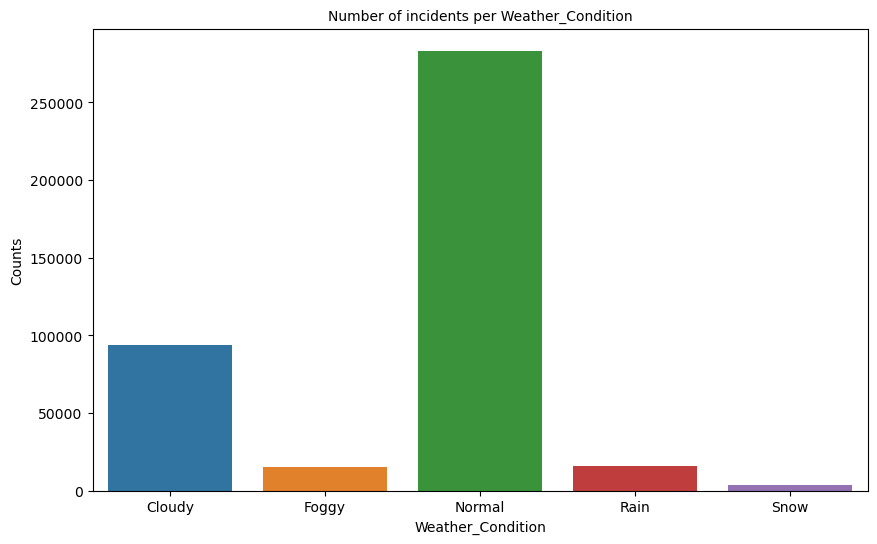

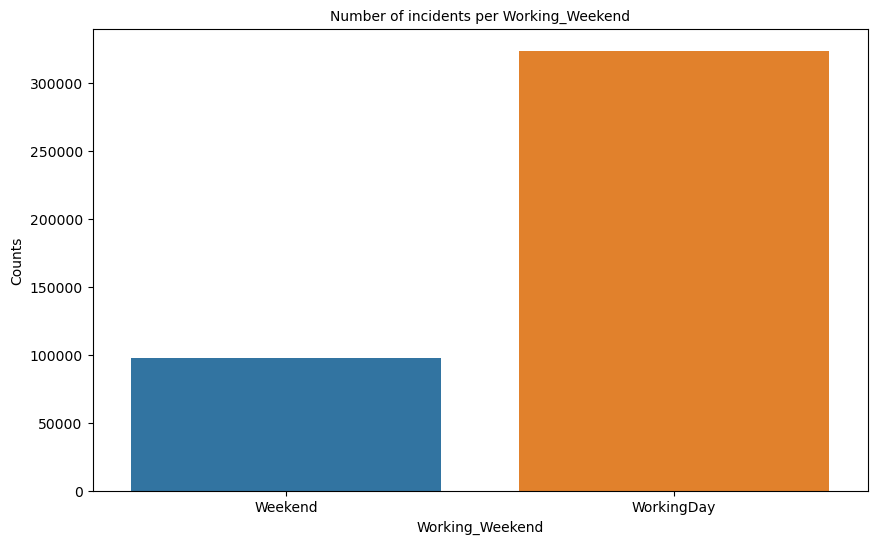

In [13]:
# Analisi barplot variabili categoriche/discrete di interesse
discrete_features=['State','month','season','day_of_the_week','hour','Weather_Condition','Working_Weekend']
df.createOrReplaceTempView("Incidents_Data")

for feature in discrete_features:
    feature_freq = spark.sql(f"SELECT {feature}, COUNT(*) as count FROM Incidents_Data GROUP BY {feature}").toPandas()
    feature_freq = feature_freq.sort_values(by=feature)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature, y="count", data=feature_freq)
    plt.xlabel(feature, size=10)
    plt.ylabel("Counts", size=10)
    plt.title(f"Number of incidents per {feature}", size=10)
    plt.show()

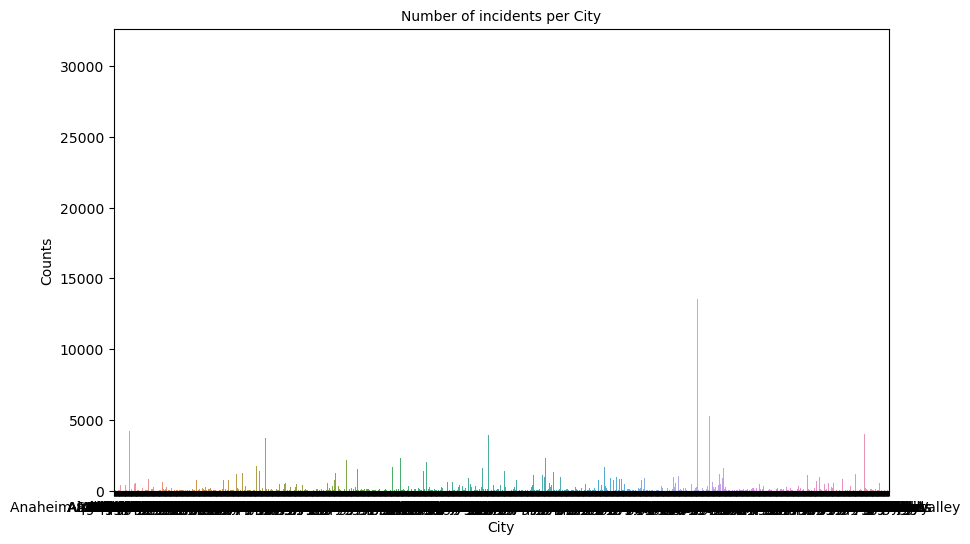

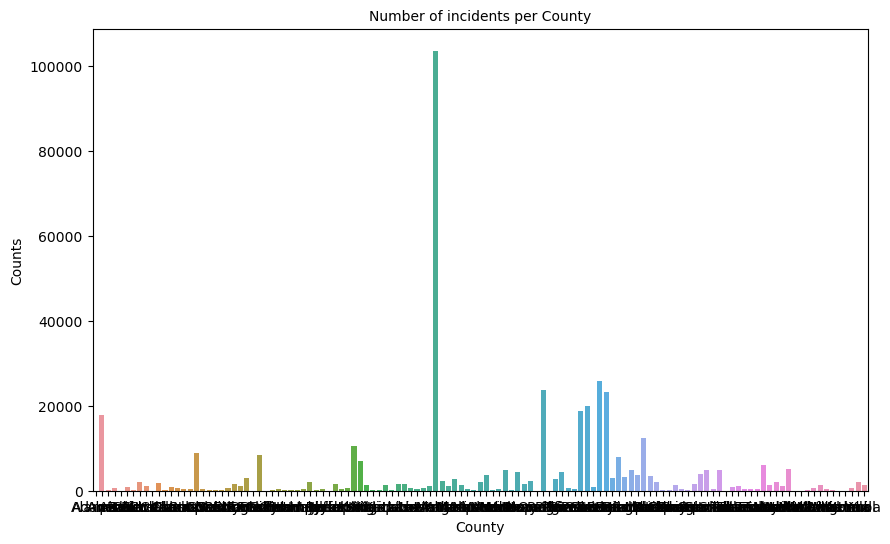

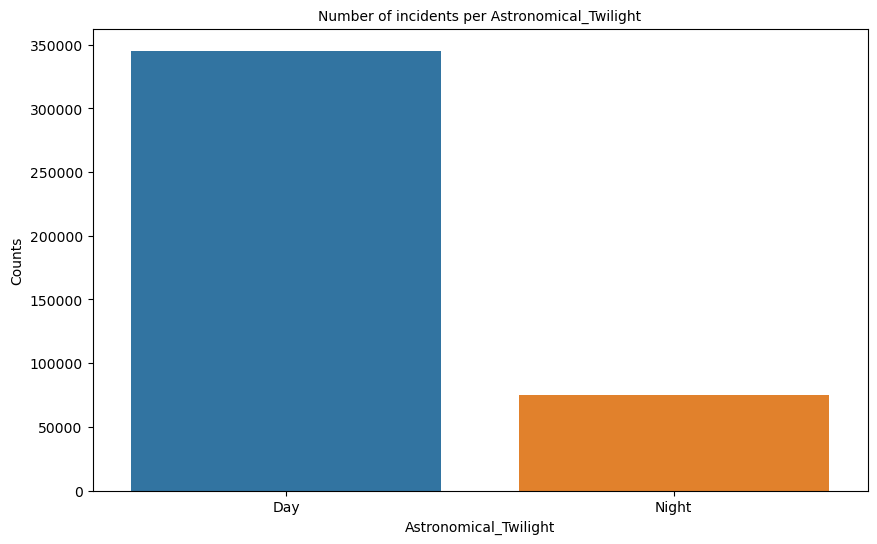

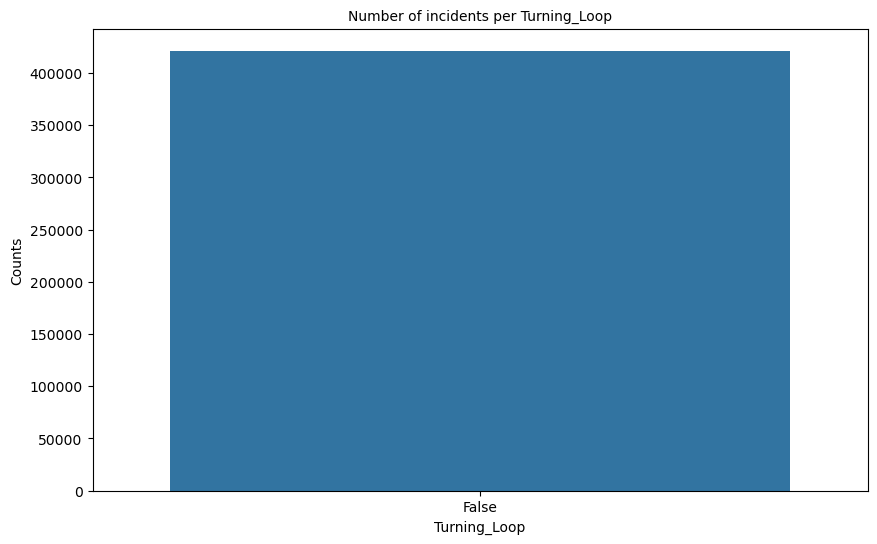

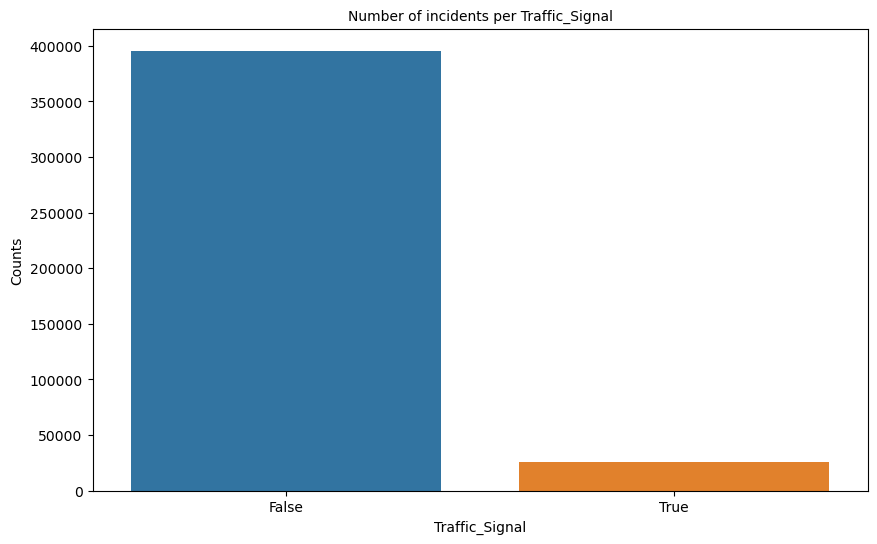

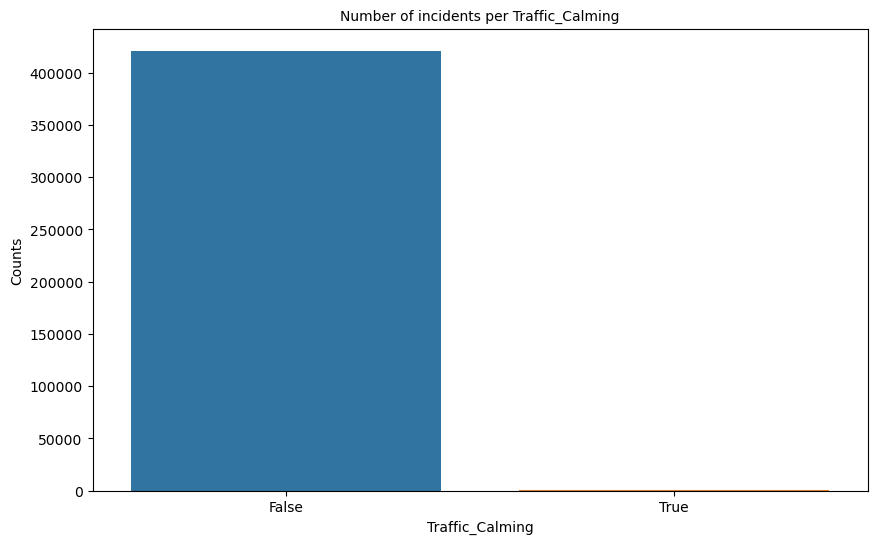

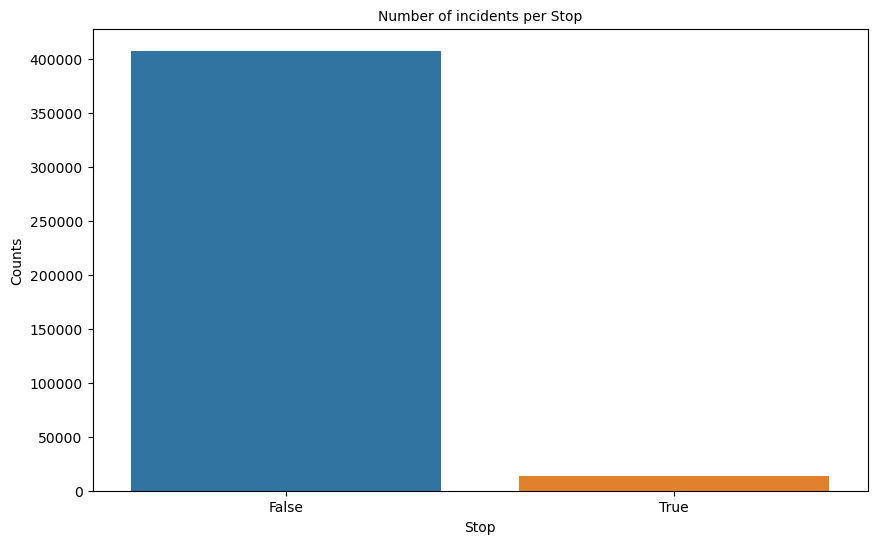

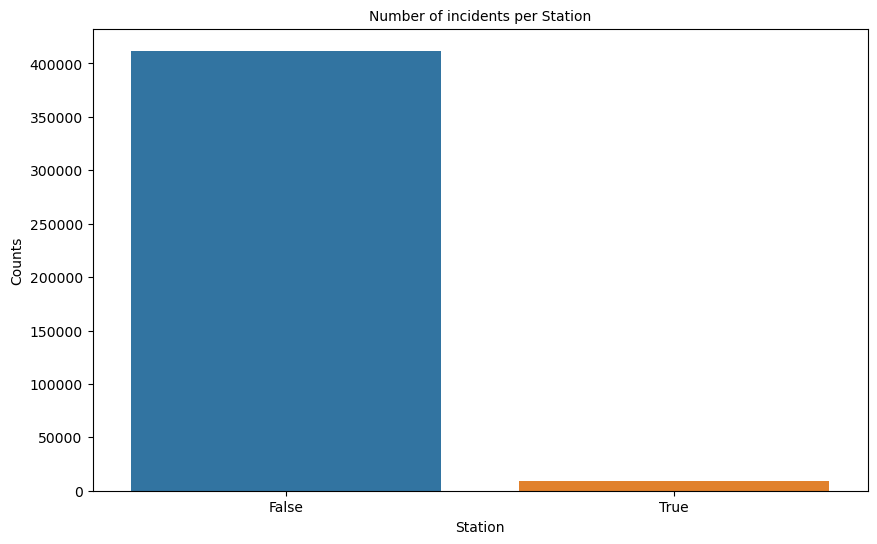

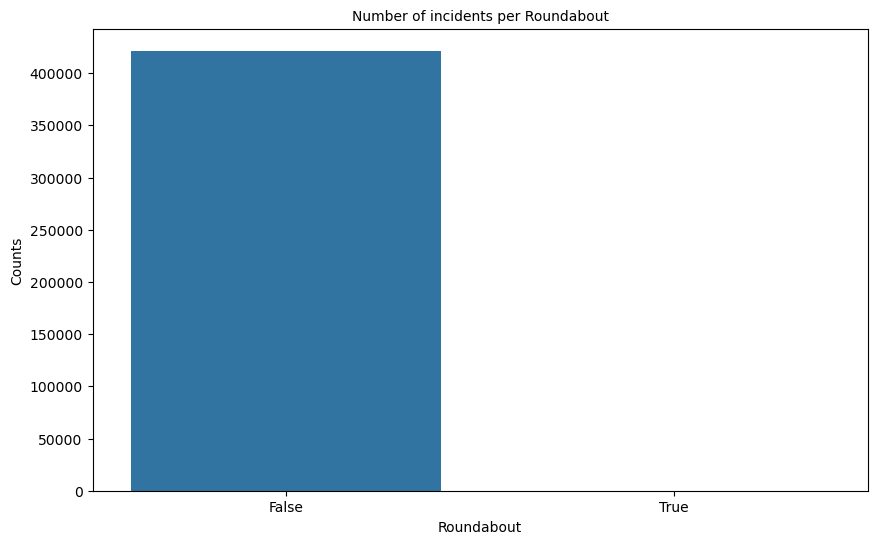

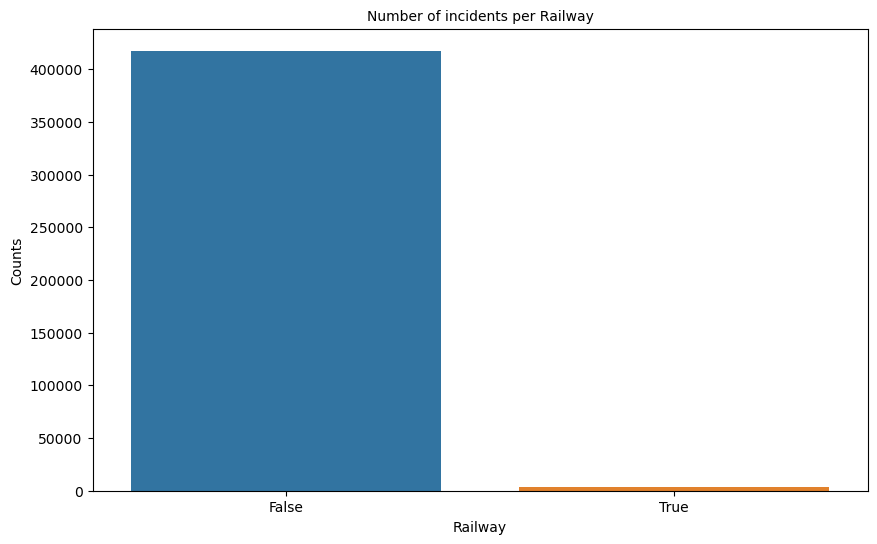

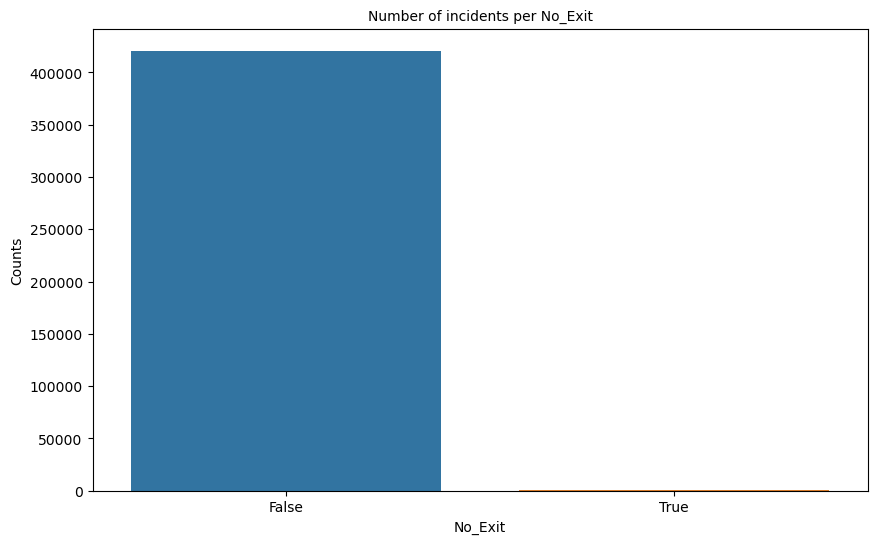

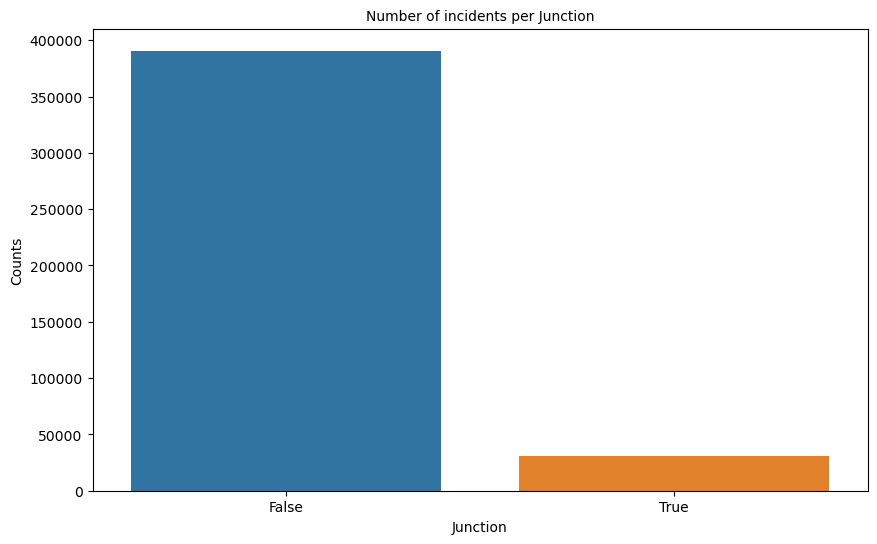

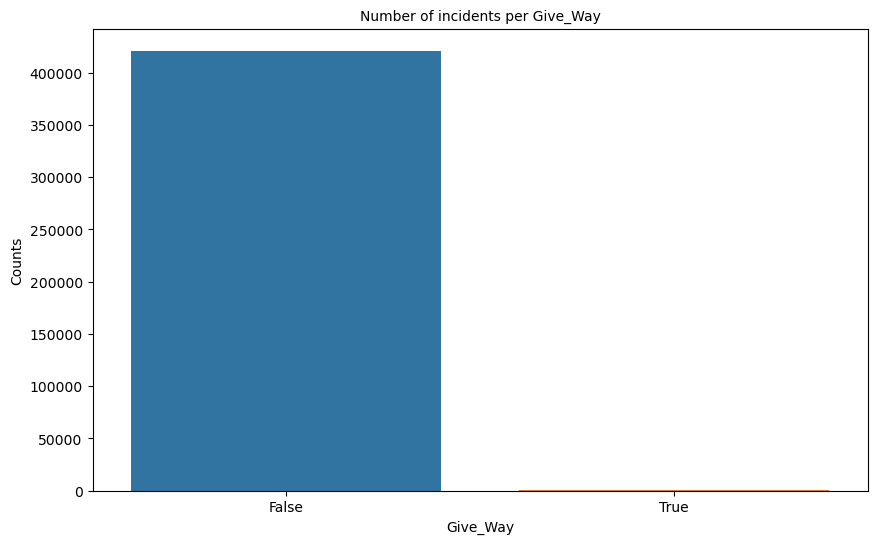

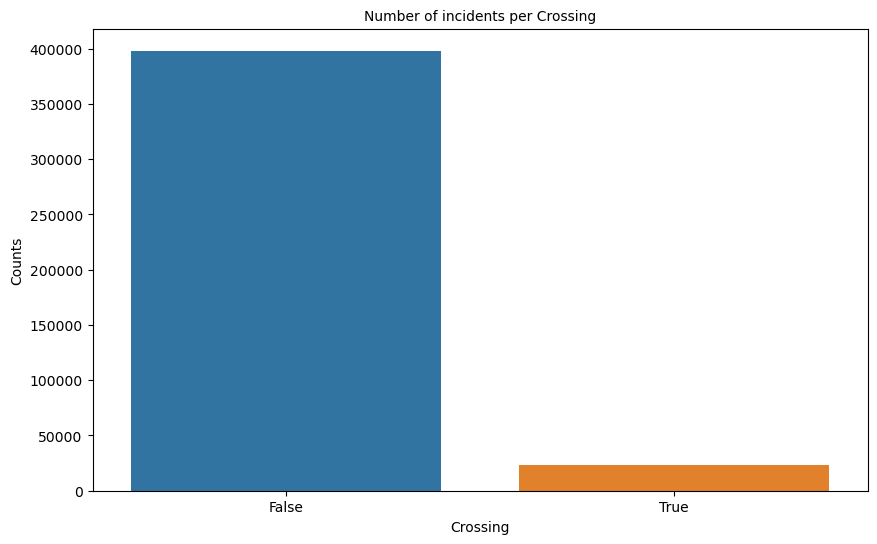

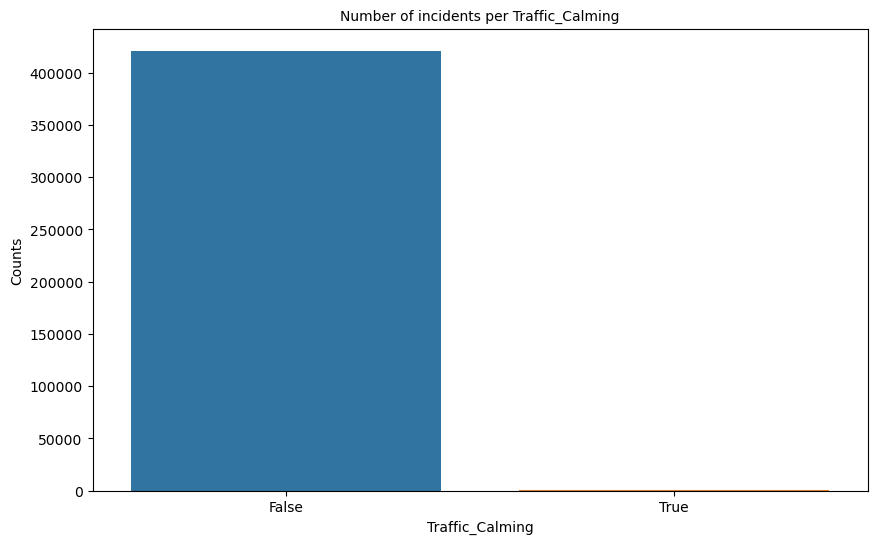

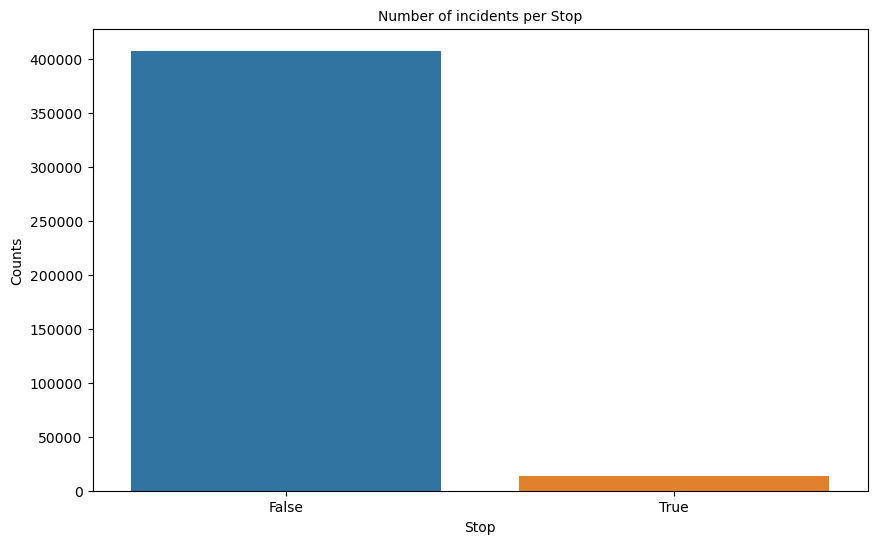

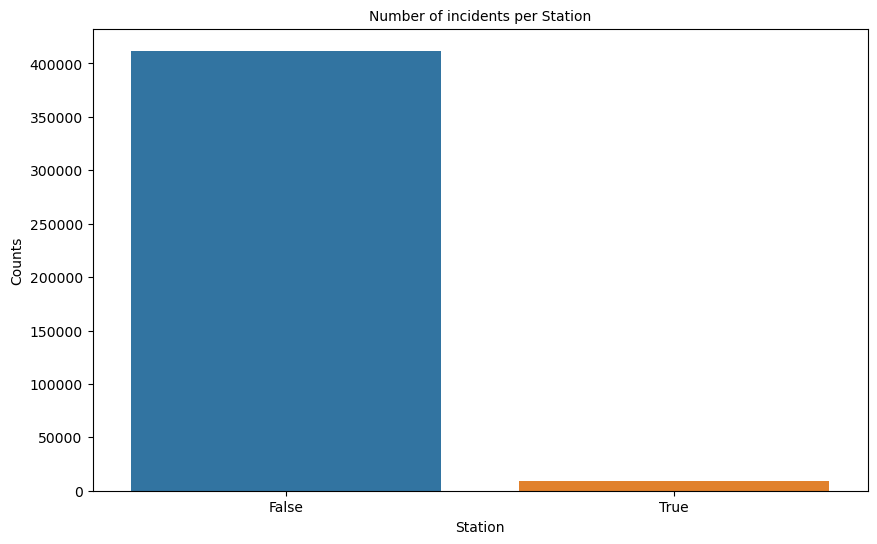

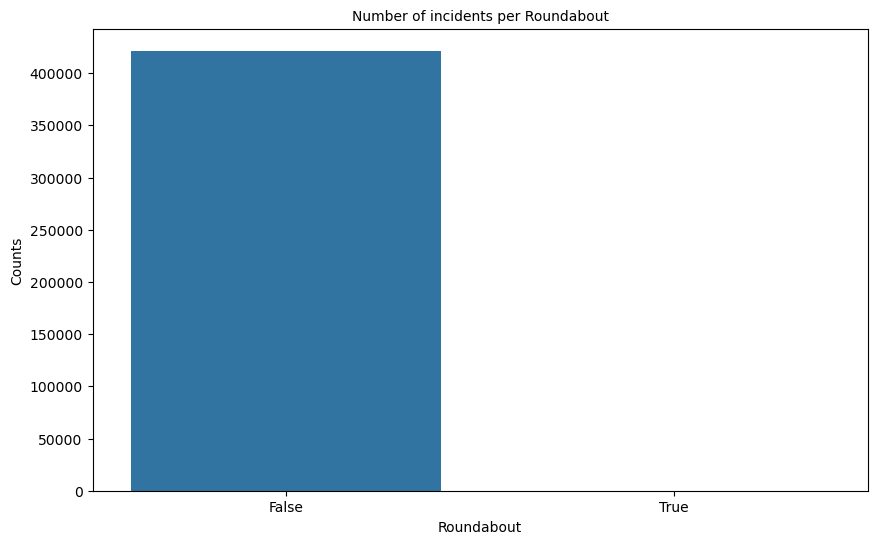

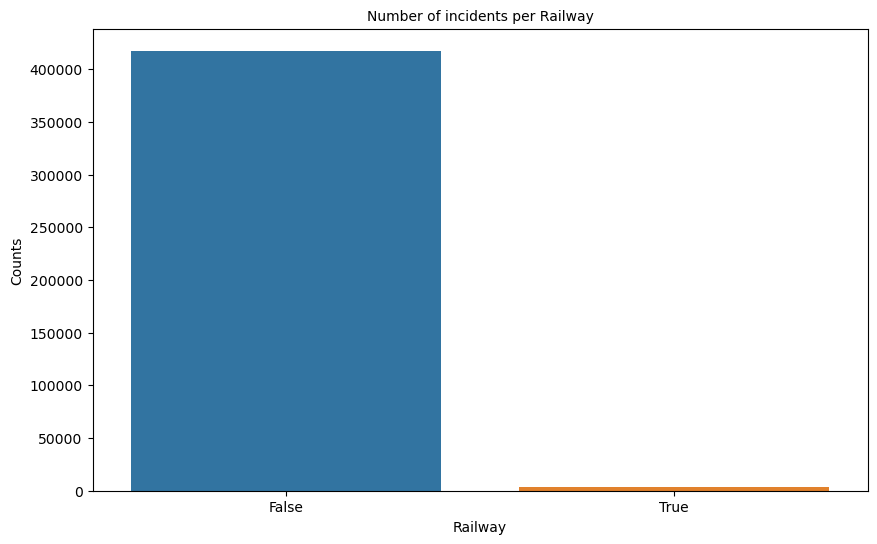

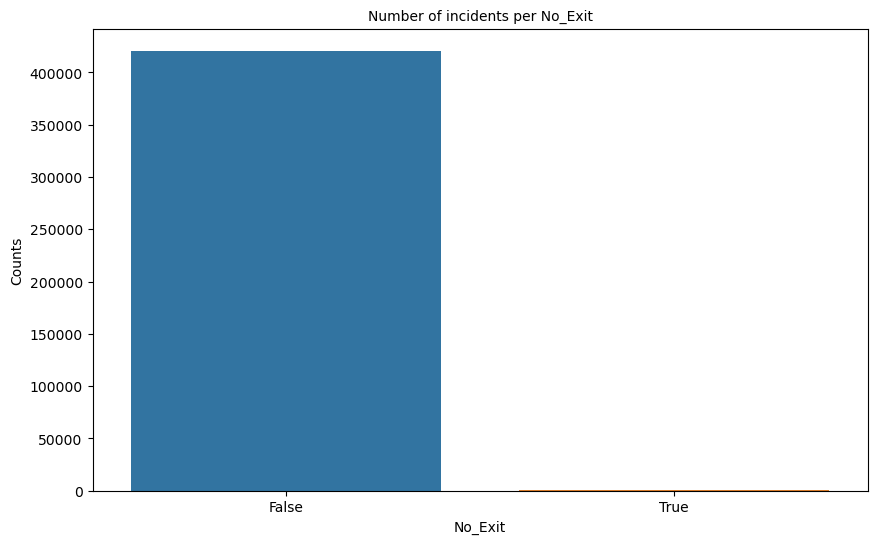

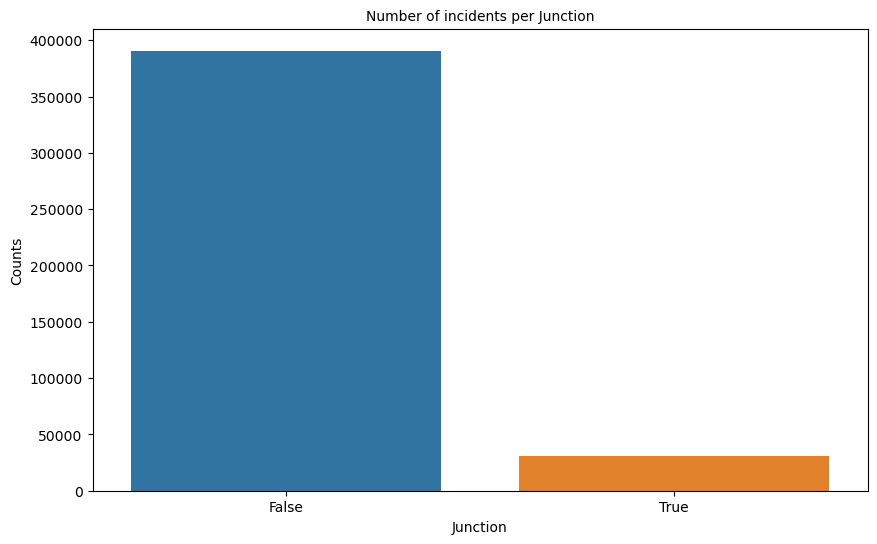

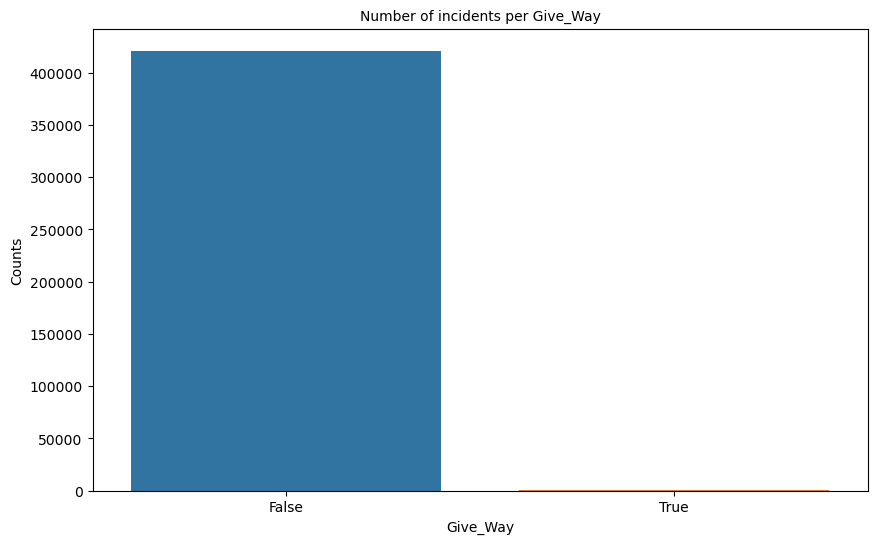

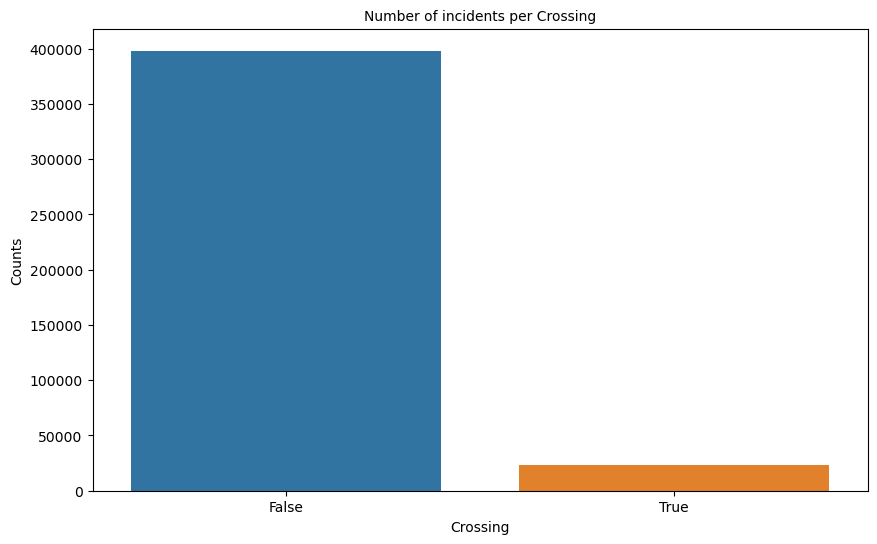

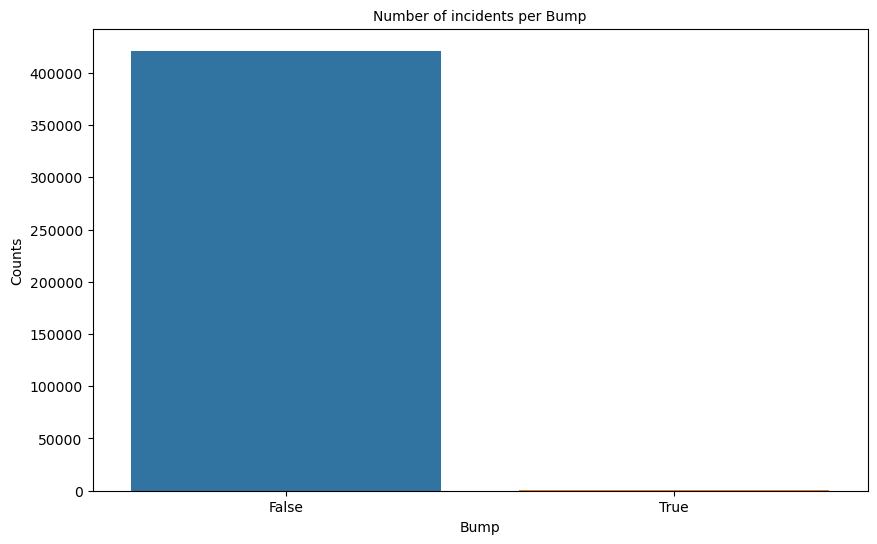

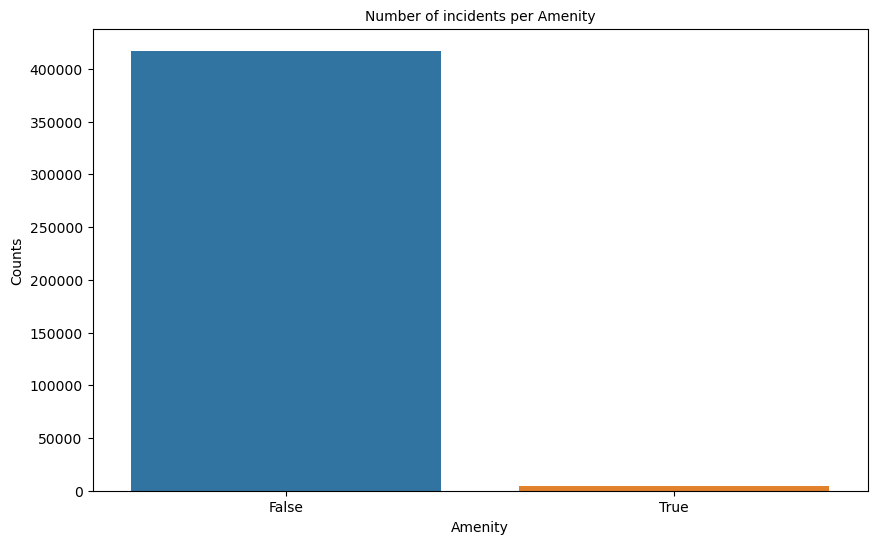

In [14]:
discrete_features=['City','County','Astronomical_Twilight','Turning_Loop','Traffic_Signal','Traffic_Calming','Stop','Station','Roundabout','Railway',
                   'No_Exit','Junction','Give_Way','Crossing','Traffic_Calming','Stop','Station','Roundabout','Railway','No_Exit','Junction','Give_Way','Crossing'
                   ,'Bump','Amenity']
df.createOrReplaceTempView("Incidents_Data")

for feature in discrete_features:
    feature_freq = spark.sql(f"SELECT {feature}, COUNT(*) as count FROM Incidents_Data GROUP BY {feature}").toPandas()
    feature_freq = feature_freq.sort_values(by=feature)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature, y="count", data=feature_freq)
    plt.xlabel(feature, size=10)
    plt.ylabel("Counts", size=10)
    plt.title(f"Number of incidents per {feature}", size=10)
    plt.show()

### histogramma che racchiude le var categoriche relative alle caratteristiche del luogo

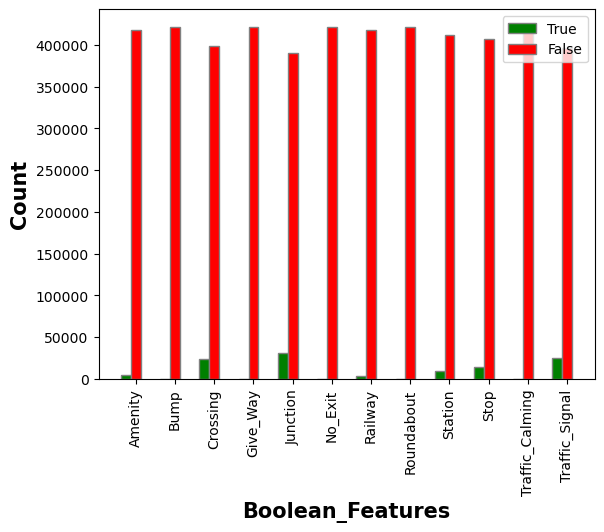

In [19]:
# Analisi barplot variabili booleane
boolean_features=['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']
lista_true=[]
lista_false=[]
for feature in boolean_features:
    feature_freq = spark.sql(f"SELECT {feature}, COUNT(*) as count FROM Incidents_Data GROUP BY {feature}").toPandas()
    feature_freq = feature_freq.sort_values(by=feature)
    #print(feature_freq)
    count=list(feature_freq['count'])
    if len(count)==2:
        lista_true.append(count[1])
        lista_false.append(count[0])
    else:
        if feature_freq[feature]=='False':
            lista_false.append(count[0])
        else:
            lista_true.append(count[0])
barWidth=0.25
br1 = np.arange(len(lista_true)) 
br2 = [x + barWidth for x in br1] 
plt.bar(br1, lista_true, color ='g', width = barWidth, 
        edgecolor ='grey', label ='True') 
plt.bar(br2, lista_false, color ='r', width = barWidth, 
        edgecolor ='grey', label ='False') 
plt.xlabel('Boolean_Features', fontweight ='bold', fontsize = 15) 
plt.ylabel('Count', fontweight ='bold', fontsize = 15) 
plt.xticks([r+barWidth  for r in range(len(lista_true))], 
        boolean_features, rotation='vertical')
 
plt.legend()
plt.show()

In [ ]:
#Checking missing value
missing = df.select([count(when(isnull("Turning_Loop"), "Turning_Loop")).alias("Turning_Loop")])
missing.show()

dagli istogrammi decido di droppare turning loop perchè costante ed ho verificato che non ha missing value. 

#### RUNNARE (SOLO PER ME)
questa riga è importante perchè rimuovo la costante Turning loop

In [15]:
# la variabile Turning loop anche nel mio dataset risulta avere un solo valore, quindi è inutile ai fini dell'analisi. 
df=df.drop('Turning_Loop')
len(df.columns)

36

In [13]:
continuos_features=['Distance_mi', 'Temperature_F', 'Wind_Chill_F', 'Humidity_perc', 'Pressure_in', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']

>>> plotting distribution for Distance_mi


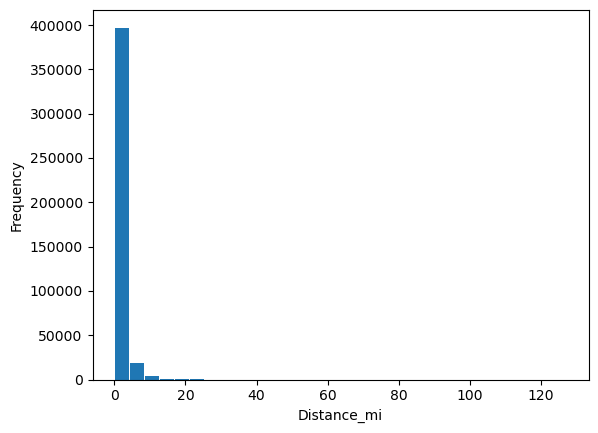

>>> plotting distribution for Temperature_F


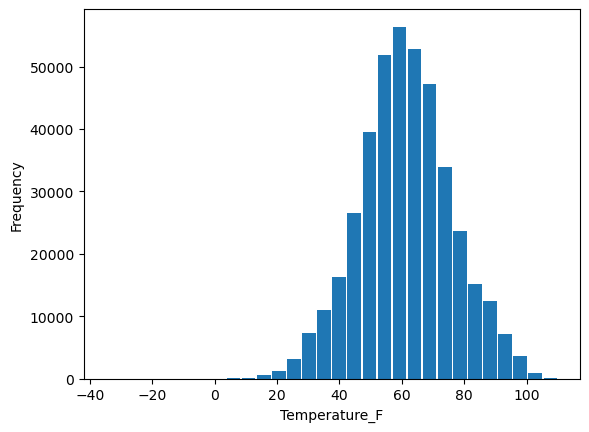

>>> plotting distribution for Wind_Chill_F


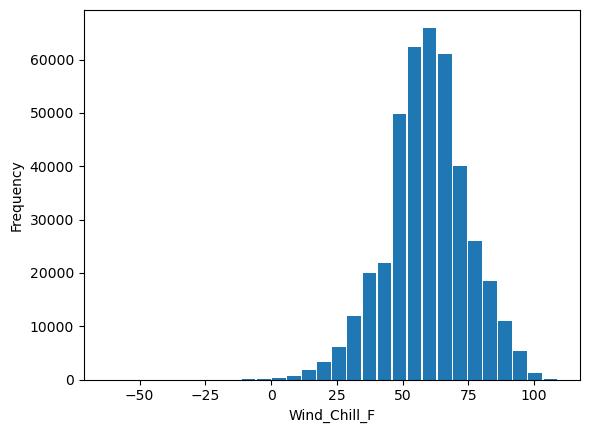

>>> plotting distribution for Humidity_perc


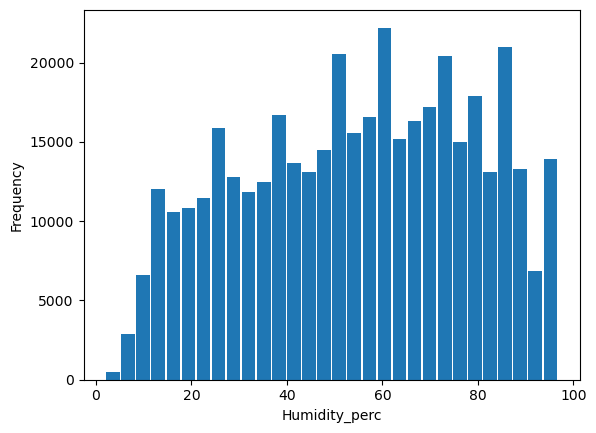

>>> plotting distribution for Pressure_in


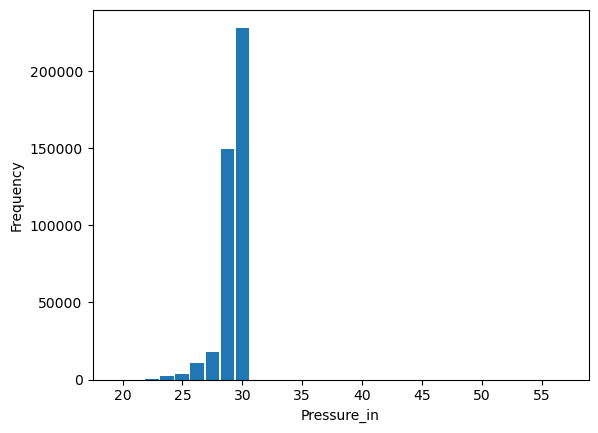

>>> plotting distribution for Visibility_mi


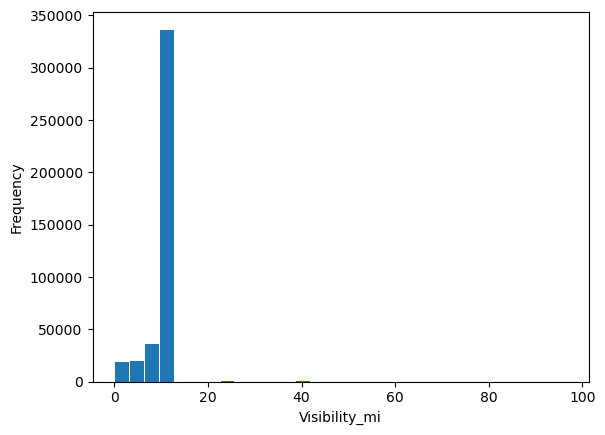

>>> plotting distribution for Wind_Speed_mph


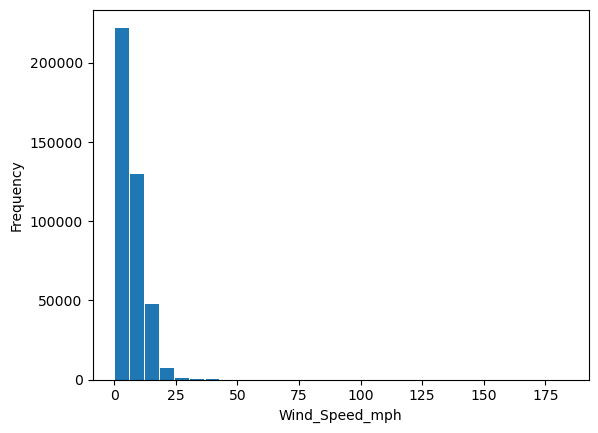

>>> plotting distribution for Precipitation_in


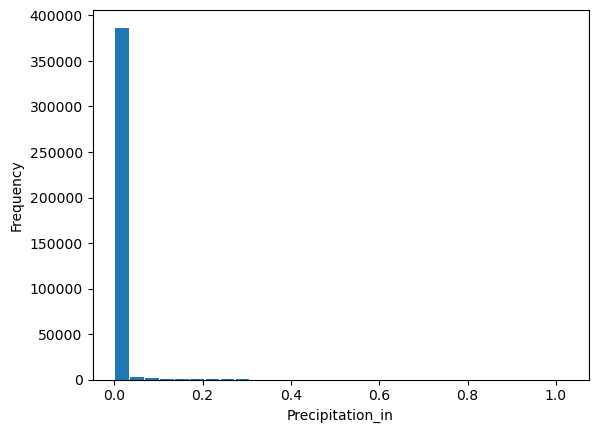

In [16]:
# Analisi distribuzione variabili continue
continuos_features=['Distance_mi', 'Temperature_F', 'Wind_Chill_F', 'Humidity_perc', 'Pressure_in', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']
df.createOrReplaceTempView("Incidents_Data")

# Itera attraverso le colonne e crea gli istogrammi
for col in continuos_features:
    print(f">>> plotting distribution for {col}")
    query = spark.sql(f'SELECT {col} FROM Incidents_Data') 
    h = query.select(col).rdd.flatMap(lambda x: x).histogram(30) # seleziono colonna specificata dalla query poi converto tutto in un RDD e applico la funzione flatMap per "appiattire" i valori in un singolo elenco. Infine creo istogramma diviso in 50 bin e restituisco una tupla contenente i bin e le frequenze.
    
    # traspone la tupla ottenuta dall'istogramma per ottenere una lista di tuple, ognuna rappresentante un bin e la sua frequenza.
    dfh = pd.DataFrame(
        list(zip(*h)), 
        columns=['bin', 'frequency']
    )
    # estraggo dai dal dataframe pandas per ottenere i bin e le frequenze necessari per il plotting
    bins = dfh['bin']
    counts = dfh['frequency']
    #  classic pandas syntax
    plt.hist(bins, len(bins), weights=counts, rwidth=0.9)
    plt.xlabel(f'{col}', size=10)
    plt.ylabel("Frequency", size=10)
    #plt.grid(True) 
    plt.show()


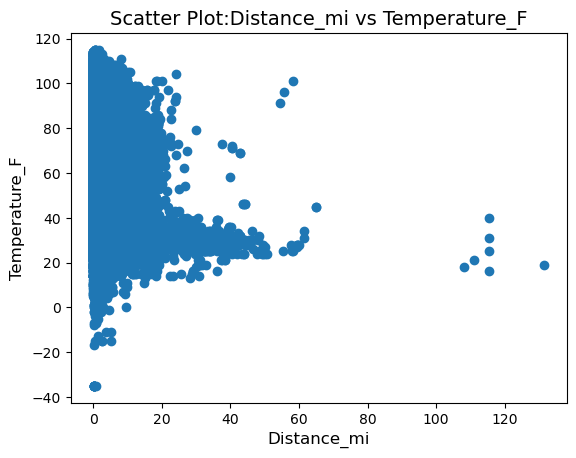

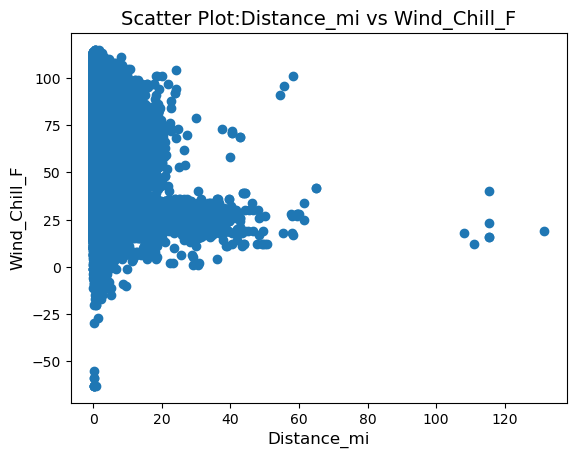

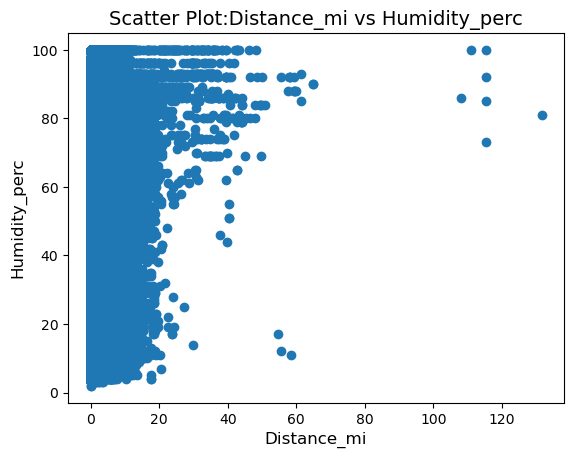

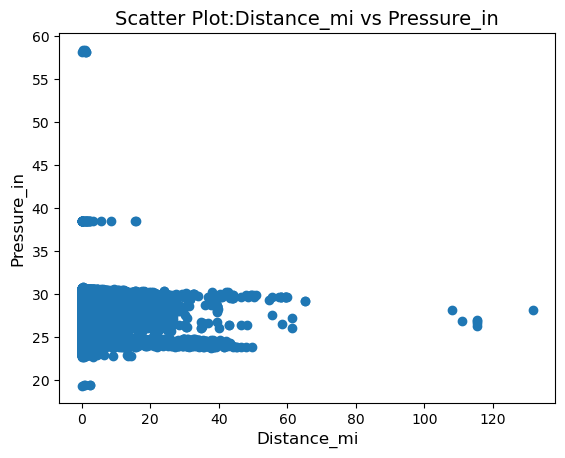

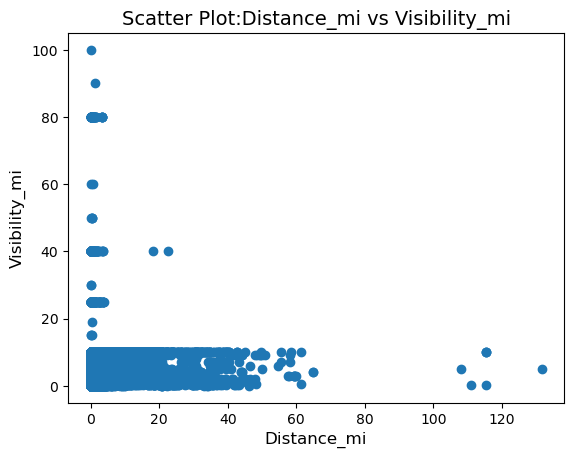

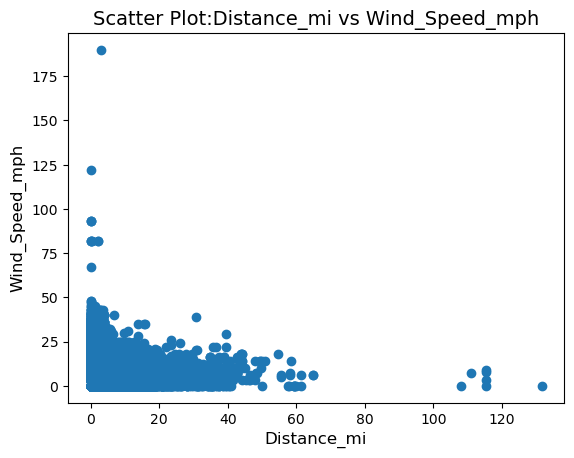

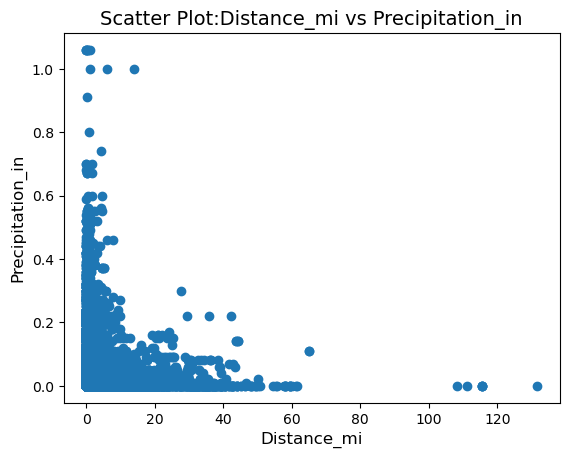

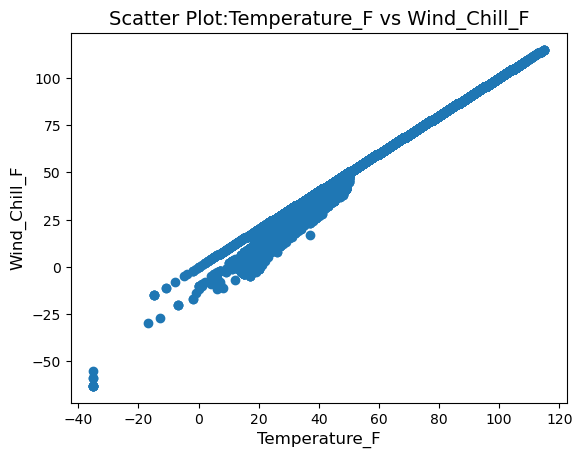

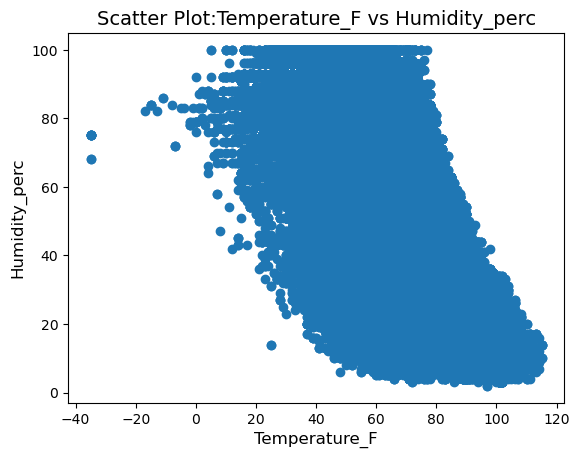

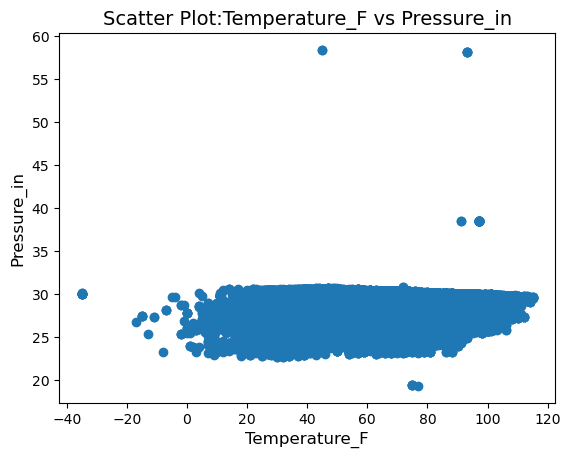

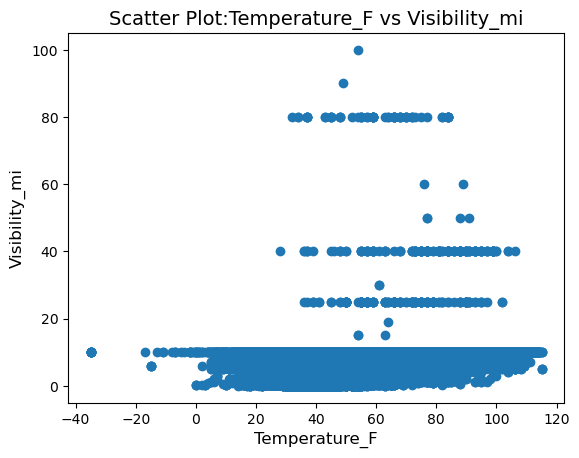

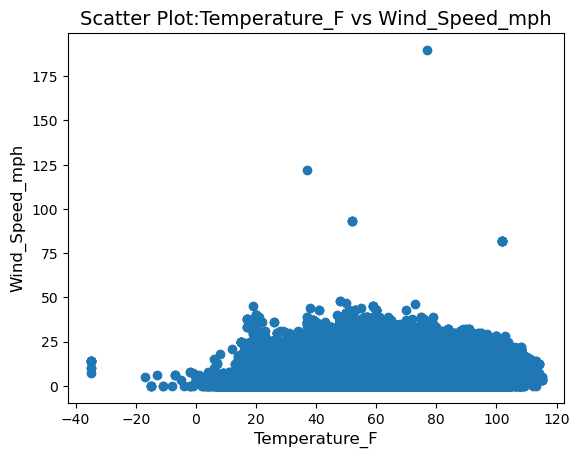

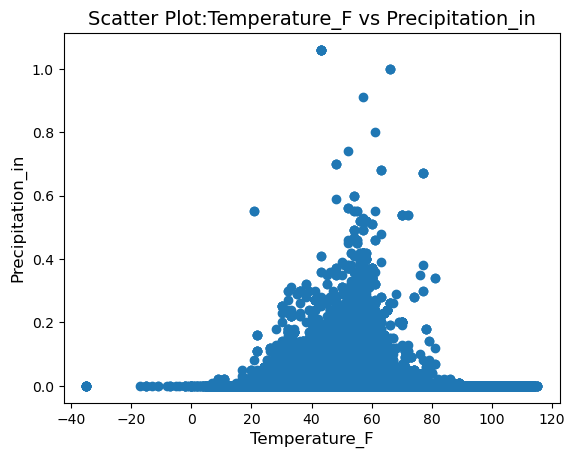

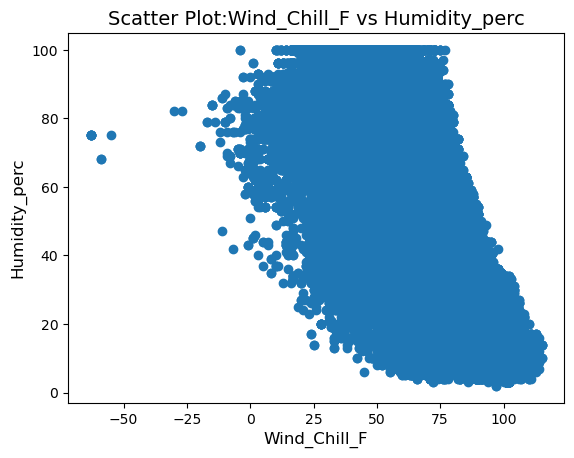

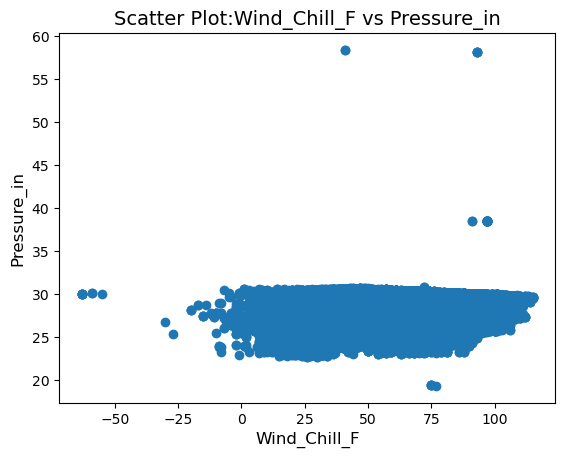

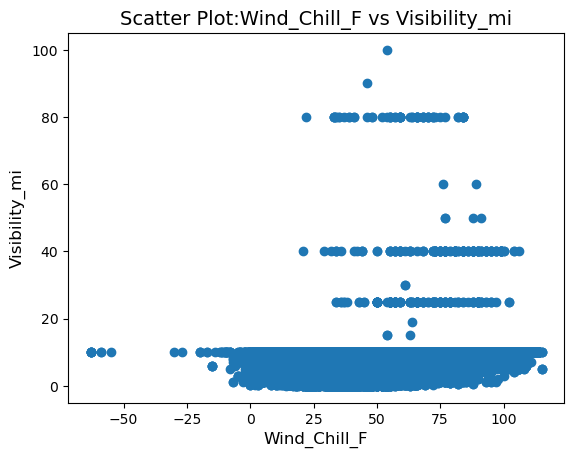

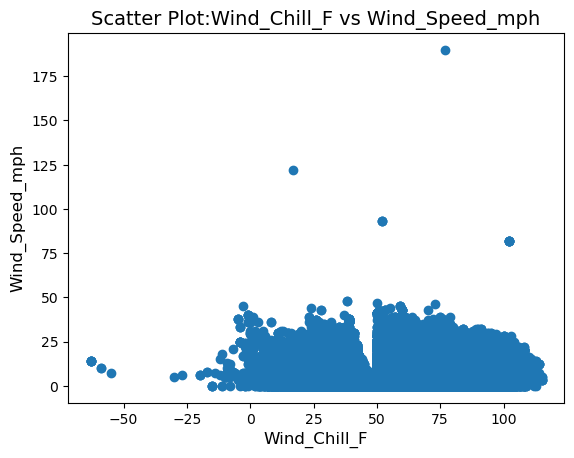

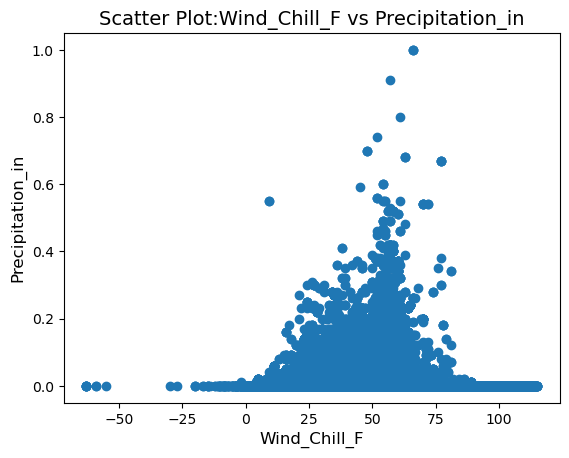

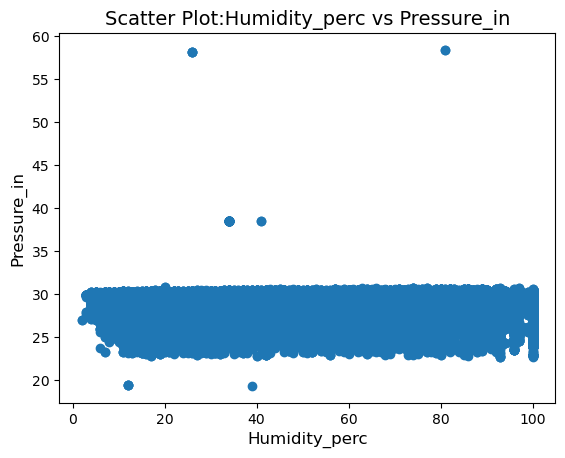

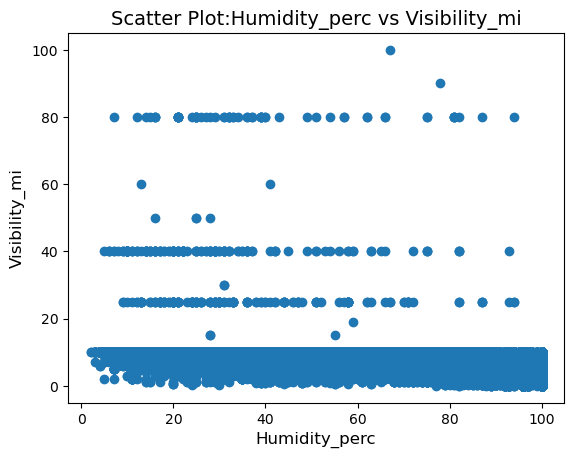

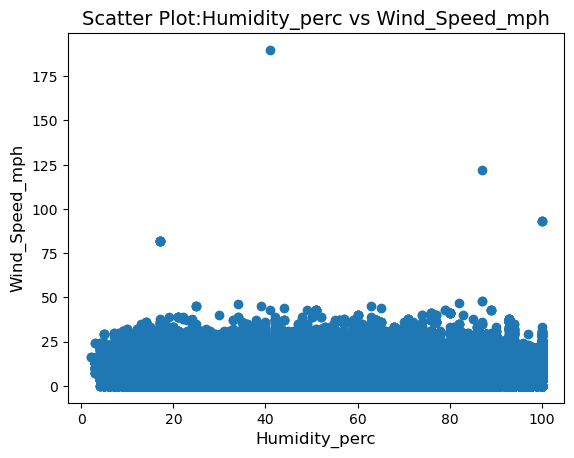

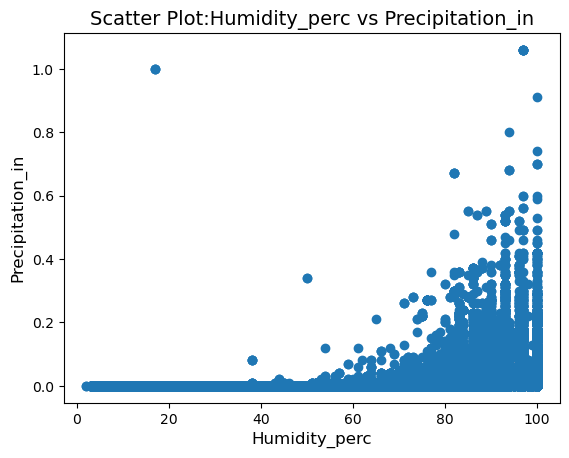

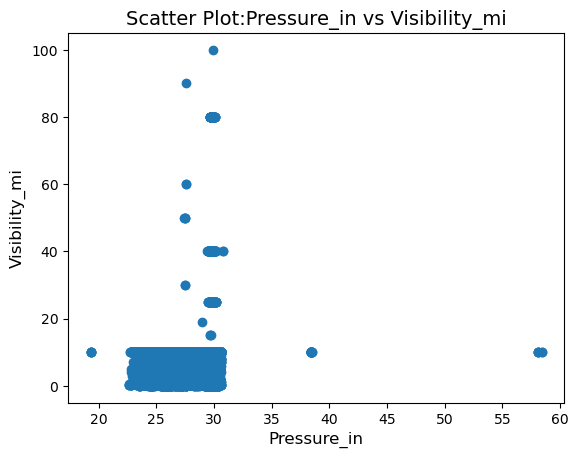

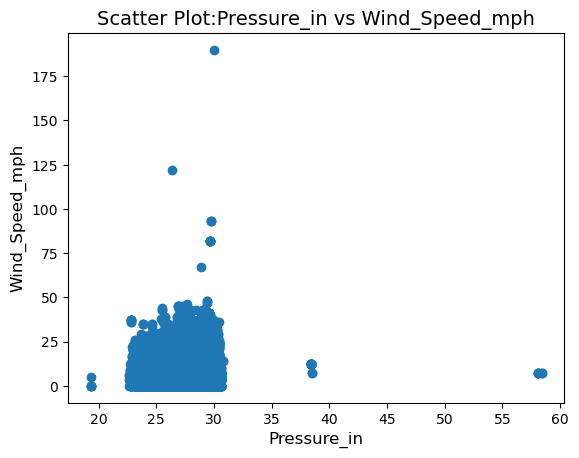

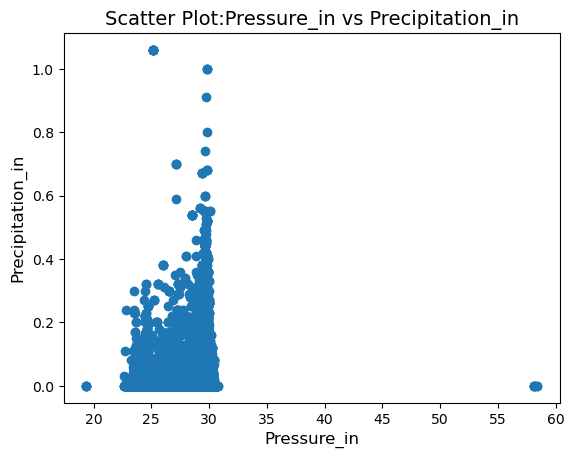

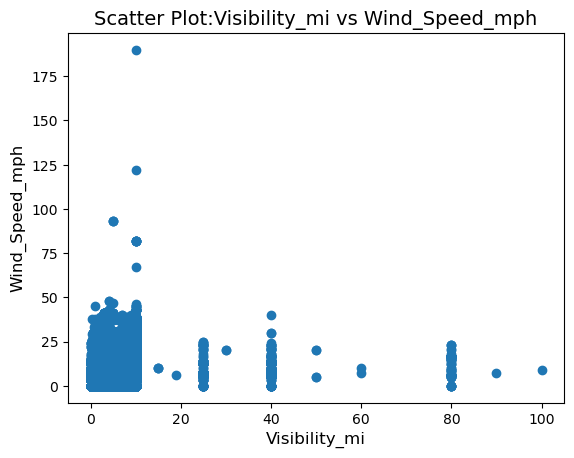

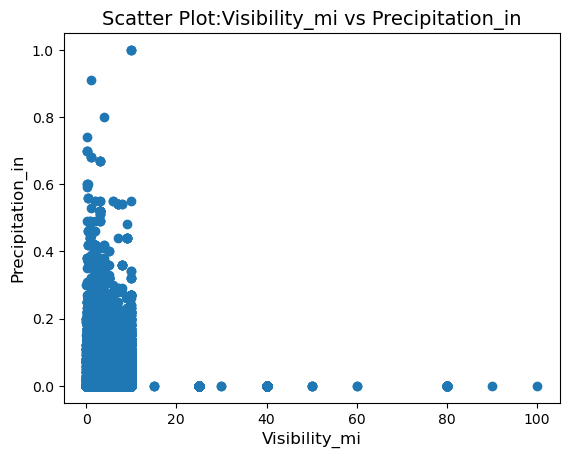

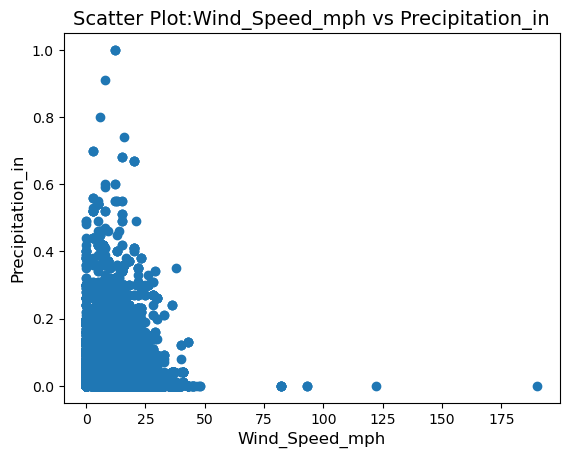

In [17]:
# Scatterplots for continuos features
i=0
for el1 in continuos_features:
    for el2 in continuos_features[i+1:]:
        filtered_df = df.filter(df[el1].isNotNull() & df[el2].isNotNull())

        data= filtered_df.select(el1, el2).collect()
        x = [row[el1] for row in data]
        y = [row[el2] for row in data]

        # Crea lo scatterplot utilizzando matplotlib
        plt.scatter(x, y)
        plt.xlabel(el1, size=12)
        plt.ylabel(el2, size=12)
        plt.title("Scatter Plot:"+ el1 +" vs "+el2, size=14)
        plt.show()
    i+=1

si osseva che Temp e wind chill_F sono altamente correlati: quindi ci aspettiamo un alto indice di corrrelazione e per questo ne teniamo traccia per fillare i missing values (l'uno dell'altro).  a

In [14]:
df.take(1)

[Row(ID='A-512231', Severity=1, Start_Time=datetime.datetime(2022, 9, 8, 2, 2, 5), Start_Lat=34.521172, Start_Lng=-117.958076, Distance_mi=0.0, City='Littlerock', County='Los Angeles', State='CA', Temperature_F=86.0, Wind_Chill_F=86.0, Humidity_perc=28.0, Pressure_in=27.35, Visibility_mi=10.0, Wind_Direction='W', Wind_Speed_mph=6.0, Precipitation_in=0.0, Weather_Condition='Fair', Amenity=False, Bump=False, Crossing=False, Give_Way=False, Junction=False, No_Exit=False, Railway=False, Roundabout=False, Station=False, Stop=False, Traffic_Calming=False, Traffic_Signal=False, Turning_Loop=False, Astronomical_Twilight='Night')]

In [24]:
from pyspark.sql.functions import col
count_error = df.filter((col('Pressure_in') < 22) | (col('Pressure_in') > 32)).count()

# Stampa il risultato
print("Numero di righe con errore sulla pressione:", count_error)

Numero di righe con errore sulla pressione: 50


##### eliminio gli errori 

In [25]:
df = df.filter((col('Pressure_in') >= 22) & (col('Pressure_in') <= 32))

In [26]:
#Checking missing values

#L'HO COMMENTATA 

from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns])
missing.toPandas().T  # oppure usare il .show() della riga sotto 
#missing.show()

,0
ID,0
Severity,0
Start_Time,0
Start_Lat,0
Start_Lng,0
Distance_mi,0
City,6
County,0
State,0
Temperature_F,1627


## Fillaggio missing value

#### FILL CITY

In [14]:
def get_city(latitude, longitude,City):
    if City is None:
        geolocator = Nominatim(user_agent="ProgettoLaboratory", timeout=None)  # Sostituisci "myGeocoder" con un nome univoco
        location = geolocator.reverse(f"{latitude}, {longitude}", exactly_one=True)
        if location:
            address = location.raw
            city = address.get("address", {}).get("city")
            #state = address.get("address", {}).get("state")
            if city==None:
                if latitude==46.000781 and longitude==-118.403803:
                    return 'Walla Walla'
                elif latitude==46.000718 and longitude==-118.387357:
                    return 'Milton-Freewater'
                elif latitude==39.227415 and longitude==-120.005571:
                    return 'Kings Beach'
            return city            
    else:
        return City 
    
# c'è un ERRORE GROSSO COME UNA CASA perchè IN TEORIA devo poi verificare la county    
    
udf_city = udf(get_city, StringType())
df = df.withColumn("City_full", udf_city(col('Start_Lat'), col('Start_Lng'), col('City')))

In [15]:
df.createOrReplaceTempView("missingCity")
query = spark.sql(f'SELECT City_full,City,Start_Lat,Start_Lng FROM missingCity m WHERE m.City IS NULL') 
query.show()

+----------------+----+---------+-----------+
|       City_full|City|Start_Lat|  Start_Lng|
+----------------+----+---------+-----------+
|     Walla Walla|NULL|46.000781|-118.403803|
|Milton-Freewater|NULL|46.000718|-118.387357|
|     Kings Beach|NULL|39.227415|-120.005571|
|Milton-Freewater|NULL|46.000718|-118.387357|
|     Kings Beach|NULL|39.227415|-120.005571|
|     Kings Beach|NULL|39.227415|-120.005571|
+----------------+----+---------+-----------+



In [16]:
df=df.drop('City') # elimino la vecchia colonna con in NULL
df=df.withColumnRenamed("City_full", "City") #rinomino la colonna con missing value

#### FILL Astronomical_Twilight

In [17]:
from pyspark.sql.functions import month,hour
# a seconda degli stati è da modificare le ore di inizio e fine giorno. 
def fill_astronomical_twilight(date, astro): 
    if astro==None:
        month_=date.month
        hour_=date.hour
        if month_>=3 and month_<=5:
            if hour_>=5 and hour_<=19:
                return 'Day'
            else:
                return 'Night'
        elif month_>=6 and month_<=8:
            if hour_>=4 and hour_<=20:
                return 'Day'
            else:
                return 'Night'
        elif month_>=9 and month_<=11:
            if hour_>=6 and hour_<=18:
                return 'Day'
            else:
                return 'Night'
        else:
            if hour_>=7 and hour_<=17:
                return 'Day'
            else:
                return 'Night'
    else:
        return astro

In [18]:
udf_fill_astronomical_twilight = udf(fill_astronomical_twilight, StringType())

In [19]:
df = df.withColumn("Astronomical_Twilight_full", udf_fill_astronomical_twilight(col('Start_Time'),col("Astronomical_Twilight")))

In [20]:
# verifico con una query che la sostituzione sia andata a buon fine 
df.createOrReplaceTempView("missingAss")
query=spark.sql('SELECT Astronomical_Twilight_full, Astronomical_Twilight FROM missingAss m WHERE m.Astronomical_Twilight IS NULL')
query.show()

+--------------------------+---------------------+
|Astronomical_Twilight_full|Astronomical_Twilight|
+--------------------------+---------------------+
|                       Day|                 NULL|
|                       Day|                 NULL|
|                     Night|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                     Night|                 NULL|
|                       Day|   

In [21]:
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull('Astronomical_Twilight_full'), 'Astronomical_Twilight_full')).alias('Astronomical_Twilight_full')])
#missing.toPandas().T
#missing.show()

In [22]:
df=df.drop('Astronomical_Twilight') # elimino la vecchia colonna con in NULL
df=df.withColumnRenamed("Astronomical_Twilight_full", "Astronomical_Twilight") #rinomino la colonna con missing value

In [ ]:
# voglio controllare quali sono i missing value restanti
#from pyspark.sql.functions import when, count, isnull
#missing = df.select([count(when(isnull(c), c)).alias(c) for c in ['Temperature_F','Wind_Chill_F','Humidity_perc','Pressure_in','Visibility_mi','Wind_Direction','Wind_Speed_mph','Precipitation_in','Weather_Condition','City','Astronomical_Twilight']])
#missing.toPandas().T
#missing.show()

###### idee per fillare 
##### Weather_Condition: 
1) verifichiamo se piove o meno: 
se piove --> rain  (basta verificare che sia >0)
se piove e la temp è minore di (Farenheit sotto lo zero) allora Snow
2) 
in tutti gli altri casi si segue la moda della città per mese ( e se troppo fine, per stagione). 

### visibility

- tego conto della i) weather condition e ii) di day-night (che implicitamente tiene conto delle temp), iii) county (es: piana padana nebbia), iv)month. 

#### precipitation_in:
stessa logica di vedere per mese/ per stagione e vediamo 


#### Temperature

In [ ]:
#df_copy=df.select('*')

In [23]:
import pyspark.sql.functions as F
from pyspark.sql import Window

window = Window.partitionBy(["County", "Astronomical_Twilight","season"]).orderBy("County", "Astronomical_Twilight","season")

In [24]:
tmpdf = df.withColumn("avg", F.avg("Temperature_F").over(window))

In [25]:
tmpdf2 = tmpdf.withColumn("Temperature_F", 
                         F.when(F.col("Temperature_F").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Temperature_F")))

In [26]:
tmpdf3 = tmpdf2.drop("avg")

In [27]:
df= tmpdf3

In [28]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull('Temperature_F'), 'Temperature_F')).alias('Temperature_F')])
#missing.toPandas().T
missing.show()

+-------------+
|Temperature_F|
+-------------+
|           29|
+-------------+



dato che con solo county non ho ancora missing value 'allargo il campo' di ricerca.

In [29]:
window = Window.partitionBy(["State", "Astronomical_Twilight","season"]).orderBy("State", "Astronomical_Twilight","season")
tmpdf = df.withColumn("avg", F.avg("Temperature_F").over(window))
tmpdf2 = tmpdf.withColumn("Temperature_F", 
                         F.when(F.col("Temperature_F").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Temperature_F")))
tmpdf3 = tmpdf2.drop("avg")
df = tmpdf3

In [30]:
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull('Temperature_F'), 'Temperature_F')).alias('Temperature_F')])
#missing.toPandas().T
missing.show()

+-------------+
|Temperature_F|
+-------------+
|            0|
+-------------+



### Fillaggio di Wind_Chill_F

In [31]:
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull('Wind_Chill_F'), 'Wind_Chill_F')).alias('Wind_Chill_F')])
#missing.toPandas().T
missing.show()

+------------+
|Wind_Chill_F|
+------------+
|       14340|
+------------+



In [32]:
window = Window.partitionBy(["County", "Astronomical_Twilight","season"]).orderBy("County", "Astronomical_Twilight","season")
tmpdf = df.withColumn("avg", F.avg("Wind_Chill_F").over(window))
tmpdf2 = tmpdf.withColumn("Wind_Chill_F", 
                         F.when(F.col("Wind_Chill_F").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Wind_Chill_F")))
tmpdf3 = tmpdf2.drop("avg")
df = tmpdf3

In [33]:
# solo righe di controllo 
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull('Wind_Chill_F'), 'Wind_Chill_F')).alias('Wind_Chill_F')])
#missing.toPandas().T
missing.show()

+------------+
|Wind_Chill_F|
+------------+
|          29|
+------------+



In [34]:
window = Window.partitionBy(["State", "Astronomical_Twilight","season"]).orderBy("State", "Astronomical_Twilight","season")
tmpdf = df.withColumn("avg", F.avg("Wind_Chill_F").over(window))
tmpdf2 = tmpdf.withColumn("Wind_Chill_F", 
                         F.when(F.col("Wind_Chill_F").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Wind_Chill_F")))
tmpdf3 = tmpdf2.drop("avg")
df = tmpdf3

In [35]:
missing = df.select([count(when(isnull('Wind_Chill_F'), 'Wind_Chill_F')).alias('Wind_Chill_F')])
#missing.toPandas().T
missing.show()

+------------+
|Wind_Chill_F|
+------------+
|           0|
+------------+



##### NB: wind è stato fillato utilizzando attributi che ho per davvero quindi sono abbastanza VERI 

### fillaggio Humidity perc

county astr e season 

In [36]:
window = Window.partitionBy(["County", "Astronomical_Twilight","season"]).orderBy("County", "Astronomical_Twilight","season")
tmpdf =df.withColumn("avg", F.avg("Humidity_perc").over(window))
tmpdf2 = tmpdf.withColumn("Humidity_perc", 
                         F.when(F.col("Humidity_perc").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Humidity_perc")))
tmpdf3 = tmpdf2.drop("avg")
df= tmpdf3

In [37]:
missing = df.select([count(when(isnull('Humidity_perc'), 'Humidity_perc')).alias('Humidity_perc')])
#missing.toPandas().T
missing.show()

+-------------+
|Humidity_perc|
+-------------+
|           29|
+-------------+



In [38]:
window = Window.partitionBy(["County","season"]).orderBy("County","season")
tmpdf = df.withColumn("avg", F.avg("Humidity_perc").over(window))
tmpdf2 = tmpdf.withColumn("Humidity_perc", 
                         F.when(F.col("Humidity_perc").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Humidity_perc")))
tmpdf3 = tmpdf2.drop("avg")
df = tmpdf3

In [39]:
missing = df.select([count(when(isnull('Humidity_perc'),'Humidity_perc')).alias('Humidity_perc')])
#missing.toPandas().T
missing.show()

+-------------+
|Humidity_perc|
+-------------+
|            0|
+-------------+



### fillaggio wind direction 
county wind_chill season 

In [40]:
missing = df.select([count(when(isnull('Wind_Direction'), 'Wind_Direction')).alias('Wind_Direction')])
#missing.toPandas().T
missing.show()

+--------------+
|Wind_Direction|
+--------------+
|         12830|
+--------------+



In [41]:
window = Window.partitionBy(["County","Wind_Chill_F","season"]).orderBy("County","Wind_Chill_F","season")
tmpdf = df.withColumn("avg", F.avg("Wind_Chill_F").over(window))
tmpdf2 = tmpdf.withColumn("Wind_Chill_F", 
                         F.when(F.col("Wind_Chill_F").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Wind_Chill_F")))
tmpdf3 = tmpdf2.drop("avg")
df = tmpdf3

In [ ]:
missing = df.select([count(when(isnull('Wind_Direction'), 'Wind_Direction')).alias('Wind_Direction')])
#missing.toPandas().T
missing.show()

In [42]:
window = Window.partitionBy(["State","Wind_Chill_F","season"]).orderBy("County","Wind_Chill_F","season")
tmpdf = df.withColumn("avg", F.avg("Wind_Chill_F").over(window))
tmpdf2 = tmpdf.withColumn("Wind_Direction", 
                         F.when(F.col("Wind_Chill_F").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Wind_Chill_F")))
tmpdf3 = tmpdf2.drop("avg")
df = tmpdf3

In [43]:
missing = df.select([count(when(isnull('Wind_Direction'), 'Wind_Direction')).alias('Wind_Direction')])
#missing.toPandas().T
missing.show()

+--------------+
|Wind_Direction|
+--------------+
|             0|
+--------------+



### fillaggio Wind Speed
county Wind_Chill_F season

state 

In [ ]:
missing = df.select([count(when(isnull('Wind_Speed_mph'), 'Wind_Speed_mph')).alias('Wind_Speed_mph')])
#missing.toPandas().T
missing.show()

In [44]:
window = Window.partitionBy(["County","Wind_Chill_F","season"]).orderBy("County","Wind_Chill_F","season")
tmpdf = df.withColumn("avg", F.avg("Wind_Speed_mph").over(window))
tmpdf2 = tmpdf.withColumn("Wind_Speed_mph", 
                         F.when(F.col("Wind_Speed_mph").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Wind_Speed_mph")))
tmpdf3 = tmpdf2.drop("avg")
df = tmpdf3

In [45]:
missing = df.select([count(when(isnull('Wind_Speed_mph'), 'Wind_Speed_mph')).alias('Wind_Speed_mph')])
#missing.toPandas().T
missing.show()

+--------------+
|Wind_Speed_mph|
+--------------+
|          7293|
+--------------+



In [46]:
window = Window.partitionBy(["State","Wind_Chill_F","season"]).orderBy("State","Wind_Chill_F","season")
tmpdf = df.withColumn("avg", F.avg("Wind_Speed_mph").over(window))
tmpdf2 = tmpdf.withColumn("Wind_Speed_mph", 
                         F.when(F.col("Wind_Speed_mph").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Wind_Speed_mph")))
tmpdf3 = tmpdf2.drop("avg")
df = tmpdf3

In [ ]:
missing = df.select([count(when(isnull('Wind_Speed_mph'), 'Wind_Speed_mph')).alias('Wind_Speed_mph')])
#missing.toPandas().T
missing.show()

In [47]:
window = Window.partitionBy(["County","season"]).orderBy("County","season")
tmpdf = df.withColumn("avg", F.avg("Wind_Speed_mph").over(window))
tmpdf2 = tmpdf.withColumn("Wind_Speed_mph", 
                         F.when(F.col("Wind_Speed_mph").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Wind_Speed_mph")))
tmpdf3 = tmpdf2.drop("avg")
df = tmpdf3

In [48]:
missing = df.select([count(when(isnull('Wind_Speed_mph'), 'Wind_Speed_mph')).alias('Wind_Speed_mph')])
#missing.toPandas().T
missing.show()

+--------------+
|Wind_Speed_mph|
+--------------+
|             0|
+--------------+



### fillaggio Precipitation 

In [ ]:
missing = df.select([count(when(isnull('Precipitation_in'), 'Precipitation_in')).alias('Precipitation_in')])
#missing.toPandas().T
missing.show()
#numero originario 

In [49]:
window = Window.partitionBy(["City","month"]).orderBy("City","month")
tmpdf = df.withColumn("mode", F.mode("Precipitation_in").over(window)) # qui abbiamo usato la MODE
tmpdf2 = tmpdf.withColumn("Precipitation_in", 
                         F.when(F.col("Precipitation_in").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Precipitation_in")))
tmpdf3 = tmpdf2.drop("mode")
df = tmpdf3

In [50]:
missing = df.select([count(when(isnull('Precipitation_in'), 'Precipitation_in')).alias('Precipitation_in')])
#missing.toPandas().T
missing.show()

+----------------+
|Precipitation_in|
+----------------+
|           19605|
+----------------+



rimangono dei missing value quindi allargo su County

In [51]:
window = Window.partitionBy(["County","month"]).orderBy("County","month")
tmpdf = df.withColumn("mode", F.mode("Precipitation_in").over(window))
tmpdf2 = tmpdf.withColumn("Precipitation_in", 
                         F.when(F.col("Precipitation_in").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Precipitation_in")))
tmpdf3 = tmpdf2.drop("mode")
df = tmpdf3

In [52]:
missing = df.select([count(when(isnull('Precipitation_in'), 'Precipitation_in')).alias('Precipitation_in')])
#missing.toPandas().T
missing.show()

+----------------+
|Precipitation_in|
+----------------+
|               0|
+----------------+



In [ ]:
#window = Window.partitionBy(["County","season"]).orderBy("County","season")
#tmpdf = df.withColumn("mode", F.mode("Precipitation_in").over(window))
#tmpdf2 = tmpdf.withColumn("Precipitation_in", 
#                         F.when(F.col("Precipitation_in").isNull(),
#                                F.col("mode"))
#                               .otherwise(F.col("Precipitation_in")))
#tmpdf3 = tmpdf2.drop("mode")
#df = tmpdf3

In [ ]:
#missing = df.select([count(when(isnull('Precipitation_in'), 'Precipitation_in')).alias('Precipitation_in')])
#missing.show()

## Weather_Condition

In [53]:
def fill_Weather_Condition(precipitation,temperature, weather): 
    if weather is None:
        if precipitation>0 and temperature>32:
            return 'Rain'
        elif precipitation>0 and temperature<=32:
            return 'Snow'
        else:
            return weather
    else: 
        return weather

In [54]:
udf_fill_Weather_Condition = udf(fill_Weather_Condition, StringType())

In [55]:
df = df.withColumn("Weather_Condition_full", fill_Weather_Condition(col('Precipitation_in'),col('Temperature_F'),col("Weather_Condition")))

In [56]:
df=df.drop('Weather_Condition') # elimino la vecchia colonna con in NULL
df=df.withColumnRenamed("Weather_Condition_full", "Weather_Condition") #rinomino la colonna con missing value

In [ ]:
#Checking missing value
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Weather_Condition"), "Weather_Condition")).alias("Weather_Condition")])
missing.show()

In [57]:
import pyspark.sql.functions as F
from pyspark.sql import Window

window = Window.partitionBy(["City","month"]).orderBy("City", "month")
tmpdf = df.withColumn("mode", F.mode("Weather_Condition").over(window))
tmpdf2 = tmpdf.withColumn("Weather_Condition", 
                         F.when(F.col("Weather_Condition").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Weather_Condition")))
tmpdf3 = tmpdf2.drop("mode")
df=tmpdf3

In [58]:
#Checking missing value
missing = df.select([count(when(isnull("Weather_Condition"), "Weather_Condition")).alias("Weather_Condition")])
missing.show()

+-----------------+
|Weather_Condition|
+-----------------+
|             5631|
+-----------------+



In [59]:
window = Window.partitionBy(["County","month"]).orderBy("County", "month")
tmpdf = df.withColumn("mode", F.mode("Weather_Condition").over(window))
tmpdf2 = tmpdf.withColumn("Weather_Condition", 
                         F.when(F.col("Weather_Condition").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Weather_Condition")))
tmpdf3 = tmpdf2.drop("mode")
df=tmpdf3

In [60]:
#Checking missing value
missing = df.select([count(when(isnull("Weather_Condition"), "Weather_Condition")).alias("Weather_Condition")])
missing.show()

+-----------------+
|Weather_Condition|
+-----------------+
|                0|
+-----------------+



In [61]:
window = Window.partitionBy(["State","month"]).orderBy("State", "month")
tmpdf = df.withColumn("mode", F.mode("Weather_Condition").over(window))
tmpdf2 = tmpdf.withColumn("Weather_Condition", 
                         F.when(F.col("Weather_Condition").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Weather_Condition")))
tmpdf3 = tmpdf2.drop("mode")
df=tmpdf3

In [62]:
#Checking missing value
missing = df.select([count(when(isnull("Weather_Condition"), "Weather_Condition")).alias("Weather_Condition")])
missing.show()

+-----------------+
|Weather_Condition|
+-----------------+
|                0|
+-----------------+



## Visibility_mi

In [63]:
Window = Window.partitionBy(["County","Weather_Condition","Astronomical_Twilight"]).orderBy("County","Weather_Condition", "Astronomical_Twilight")
tmpdf = df.withColumn("mode", F.mode("Visibility_mi").over(window))
tmpdf2 = tmpdf.withColumn("Visibility_mi", 
                         F.when(F.col("Visibility_mi").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Visibility_mi")))
tmpdf3 = tmpdf2.drop("mode")
df=tmpdf3

In [64]:
#Checking missing value
missing = df.select([count(when(isnull("Visibility_mi"), "Visibility_mi")).alias("Visibility_mi")])
missing.show()

+-------------+
|Visibility_mi|
+-------------+
|            0|
+-------------+



#### Droppo 'Pressure_in' perchè non utile per le successive analisi

In [65]:
df = df.drop("Pressure_in")

## Verifico che non ho più missing value

In [66]:
missing = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns])
#missing.toPandas().T
missing.show()

+---+--------+----------+---------+---------+-----------+------+-----+-------------+------------+-------------+-------------+--------------+--------------+----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+-----+---------------+----+------+---------------+----+---------------------+-----------------+
| ID|Severity|Start_Time|Start_Lat|Start_Lng|Distance_mi|County|State|Temperature_F|Wind_Chill_F|Humidity_perc|Visibility_mi|Wind_Direction|Wind_Speed_mph|Precipitation_in|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|month|day_of_the_week|hour|season|Working_Weekend|City|Astronomical_Twilight|Weather_Condition|
+---+--------+----------+---------+---------+-----------+------+-----+-------------+------------+-------------+-------------+--------------+--------------+----------------+-------+----+--------+--------+--------+-------+-------+----------+---

## Remove Duplicates

In [67]:
# DUPLICATE ELIMINATION
df=df.drop('ID')
df=df.distinct()
#df.count()

##### altre COSE e osservazioni 
GIA' FATTO 

-- rimuovere pressure in 

-- per outlier fare random forest 

-- correlazione 

### Save df as Csv

In [68]:
df.toPandas().to_csv('../../Datasets/West_Incidents_Cleaned.csv')

C:\Users\Davide\anaconda3\envs\pyspark_env\Lib\site-packages\pyspark\sql\pandas\types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
C:\Users\Davide\anaconda3\envs\pyspark_env\Lib\site-packages\pyspark\sql\pandas\types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):


In [69]:
df.count()

381437

osservazione del prof: gli outliers possono dare noia in fase di fillaggio di missing value se uso ad esempio la media

osservazioni

## istogrammi:
- distribuzione(label su 'Severity') degli incidenti per season, month e day_of_the_week

## Scatter + Correlazione
- si osserverà (presumibilmente) che tempe e wind chill sono correlate
(poi diremo che lo droppiamo perchè correlato con la temperatura) 